In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pandas_profiling import ProfileReport

from datetime import datetime
import pytz

import optuna

import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from textblob import TextBlob

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,IsolationForest,GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance

import sqlalchemy 
import pymysql

## Data Aquisation

In [2]:
raw_data = pd.read_csv('influencers_full.liwc.csv',on_bad_lines='skip',encoding= 'unicode_escape')

In [3]:
print(*list(raw_data.columns),sep=', ')

Account, User Name, Followers at Posting, Post Created, Post Created Date, Post Created Time, Type, Total Interactions, Likes, Comments, Views, Like and View Counts Disabled, URL, Link, Photo, Title, Description, Image Text, Sponsor Id, Sponsor Name, Total Interactions (weighted  â  Likes 1x Comments 1x ), Overperforming Score, cvfold, WC, Analytic, Clout, Authentic, Tone, WPS, Sixltr, Dic, function, pronoun, ppron, i, we, you, shehe, they, ipron, article, prep, auxverb, adverb, conj, negate, verb, adj, compare, interrog, number, quant, affect, posemo, negemo, anx, anger, sad, social, family, friend, female, male, cogproc, insight, cause, discrep, tentat, certain, differ, percept, see, hear, feel, bio, body, health, sexual, ingest, drives, affiliation, achieve, power, reward, risk, focuspast, focuspresent, focusfuture, relativ, motion, space, time, work, leisure, home, money, relig, death, informal, swear, netspeak, assent, nonflu, filler, AllPunc, Period, Comma, Colon, SemiC, QMark,

In [4]:
raw_data.shape

(299964, 116)

In [5]:
raw_data.describe()

,Followers at Posting,Total Interactions,Likes,Comments,Views,Title,Sponsor Id,Sponsor Name,Total Interactions (weighted â Likes 1x Comments 1x ),Overperforming Score,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
count,256140.000000,299964.000000,299964.000000,299964.000000,2.999640e+05,0.0,0.0,0.0,299964.000000,299958.000000,...,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000
mean,47426.511279,1794.848932,1750.957758,43.891174,1.671560e+03,NaN,NaN,NaN,1794.848932,1.073768,...,1.941717,0.540235,0.017856,0.572301,4.309720,0.839629,0.770971,1.968561,0.583866,18.639588
std,26763.017637,1902.321290,1868.306481,110.126791,2.525150e+04,NaN,NaN,NaN,1902.321290,5.675180,...,4.376725,3.571030,0.383952,3.795384,14.668332,6.810003,4.678809,4.584476,3.551831,26.961368
min,1002.000000,746.000000,208.000000,0.000000,0.000000e+00,NaN,NaN,NaN,746.000000,-14.150000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26974.000000,968.000000,943.000000,14.000000,0.000000e+00,NaN,NaN,NaN,968.000000,-1.170000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,44370.000000,1303.000000,1270.000000,26.000000,0.000000e+00,NaN,NaN,NaN,1303.000000,1.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.520000
75%,64307.500000,1998.000000,1952.000000,48.000000,0.000000e+00,NaN,NaN,NaN,1998.000000,2.100000,...,2.540000,0.000000,0.000000,0.000000,3.850000,0.000000,0.000000,2.440000,0.000000,25.000000
max,558940.000000,104703.000000,104238.000000,30761.000000,5.906940e+06,NaN,NaN,NaN,104703.000000,929.430000,...,200.000000,400.000000,50.000000,450.000000,1800.000000,1240.000000,200.000000,100.000000,200.000000,2300.000000


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299964 entries, 0 to 299963
Columns: 116 entries, Account to OtherP
dtypes: bool(1), float64(97), int64(6), object(12)
memory usage: 263.5+ MB


In [7]:
na_summary = pd.DataFrame(raw_data.isnull().sum(),columns=['na_count'])
na_summary[na_summary.na_count>0]

,na_count
Account,6
Followers at Posting,43824
URL,97
Link,97
Photo,4
Title,299964
Description,6047
Image Text,292107
Sponsor Id,299964
Sponsor Name,299964


Note that columns that encounters null values are all sitting on the instagram page side rather than the text part of the data.

### Segregate data for discovery purpose

In [8]:
instagram_data = raw_data.iloc[:,:22]
instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Views', 'Like and View Counts Disabled', 'URL',
       'Link', 'Photo', 'Title', 'Description', 'Image Text', 'Sponsor Id',
       'Sponsor Name',
       'Total Interactions (weighted  â  Likes 1x Comments 1x )',
       'Overperforming Score'],
      dtype='object')

In [9]:
instagram_data.dtypes

Account                                                       object
User Name                                                     object
Followers at Posting                                         float64
Post Created                                                  object
Post Created Date                                             object
Post Created Time                                             object
Type                                                          object
Total Interactions                                             int64
Likes                                                          int64
Comments                                                       int64
Views                                                          int64
Like and View Counts Disabled                                   bool
URL                                                           object
Link                                                          object
Photo                             

In [10]:
cols=list(instagram_data.columns)
cols[-2] = 'Total Interactions (weighted on likes 1x Comments 1x)'
instagram_data.columns = cols

In [11]:
print(*list(instagram_data.columns), sep=', ')

Account, User Name, Followers at Posting, Post Created, Post Created Date, Post Created Time, Type, Total Interactions, Likes, Comments, Views, Like and View Counts Disabled, URL, Link, Photo, Title, Description, Image Text, Sponsor Id, Sponsor Name, Total Interactions (weighted on likes 1x Comments 1x), Overperforming Score


In [12]:
train_test_ind = raw_data.iloc[:,22]

In [13]:
text_data = raw_data.iloc[:,23:]
print(*list(text_data.columns), sep=', ')

WC, Analytic, Clout, Authentic, Tone, WPS, Sixltr, Dic, function, pronoun, ppron, i, we, you, shehe, they, ipron, article, prep, auxverb, adverb, conj, negate, verb, adj, compare, interrog, number, quant, affect, posemo, negemo, anx, anger, sad, social, family, friend, female, male, cogproc, insight, cause, discrep, tentat, certain, differ, percept, see, hear, feel, bio, body, health, sexual, ingest, drives, affiliation, achieve, power, reward, risk, focuspast, focuspresent, focusfuture, relativ, motion, space, time, work, leisure, home, money, relig, death, informal, swear, netspeak, assent, nonflu, filler, AllPunc, Period, Comma, Colon, SemiC, QMark, Exclam, Dash, Quote, Apostro, Parenth, OtherP


### Datetime Encoding

In [14]:
def convert_ts(dt_str):
    ts = dt_str[:-4]
    fmt = "%Y-%m-%d %H:%M:%S"
    read_in_dt = datetime.strptime(ts,fmt)
    local_tz = pytz.timezone('US/Eastern')
    date_local = local_tz.localize(read_in_dt)
    return date_local

In [15]:
trans_ts = lambda x: convert_ts(x)

In [16]:
instagram_data.loc[:,'Post Created'] = instagram_data['Post Created'].apply(trans_ts)

In [17]:
instagram_data['PostCreatedYear'] = pd.DatetimeIndex(instagram_data['Post Created']).year
instagram_data['PostCreatedMonth'] = pd.DatetimeIndex(instagram_data['Post Created']).month
instagram_data['PostCreatedDay'] = pd.DatetimeIndex(instagram_data['Post Created']).weekday
instagram_data['PostCreatedHour'] = pd.DatetimeIndex(instagram_data['Post Created']).hour

### Drop columns that has too many NAs or not used in this study

In [18]:
instagram_data = instagram_data.drop(['Title','Sponsor Id','Sponsor Name','Post Created Date', 'Post Created Time','URL'],axis=1)

### Transformation on Link

In [19]:
instagram_data['is_linked'] = np.where(pd.isnull(instagram_data['Link']),0,1)
instagram_data = instagram_data.drop('Link',axis=1)

In [20]:
instagram_data.isnull().sum()

Account                                                       6
User Name                                                     0
Followers at Posting                                      43824
Post Created                                                  0
Type                                                          0
Total Interactions                                            0
Likes                                                         0
Comments                                                      0
Views                                                         0
Like and View Counts Disabled                                 0
Photo                                                         4
Description                                                6047
Image Text                                               292107
Total Interactions (weighted on likes 1x Comments 1x)         0
Overperforming Score                                          6
PostCreatedYear                         

## Data Discovery: Instagram page descriptive analysis

### Fill NA: Account

In [21]:
instagram_data[instagram_data.Account.isnull()]['User Name']

61463     justluxeee
98412     justluxeee
115530    justluxeee
138319    justluxeee
176068    justluxeee
232734    justluxeee
Name: User Name, dtype: object

In [22]:
instagram_data[instagram_data['User Name'] == 'justluxeee']

,Account,User Name,Followers at Posting,Post Created,Type,Total Interactions,Likes,Comments,Views,Like and View Counts Disabled,Photo,Description,Image Text,Total Interactions (weighted on likes 1x Comments 1x),Overperforming Score,PostCreatedYear,PostCreatedMonth,PostCreatedDay,PostCreatedHour,is_linked
61463,NaN,justluxeee,NaN,2020-10-08 14:42:36-04:00,Photo,2227,2198,29,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Iâm heating up ð¸@2020photography3 ð @i...,NaN,2227,1.91,2020,10,3,14,1
98412,NaN,justluxeee,NaN,2021-06-24 22:07:21-04:00,Album,1707,1647,60,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Miss Mamasð,NaN,1707,1.42,2021,6,3,22,1
115530,NaN,justluxeee,NaN,2020-11-02 16:54:32-05:00,Photo,1546,1545,1,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Not one of them,NaN,1546,1.33,2020,11,0,16,1
138319,NaN,justluxeee,NaN,2020-02-19 15:13:41-05:00,Photo,1375,1372,3,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Itâs Luxzurious to youð\nð· @capturedby...,NaN,1375,1.18,2020,2,2,15,1
176068,NaN,justluxeee,NaN,2021-06-02 13:42:25-04:00,Album,1164,1140,24,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,"i ain got no free time, everythingâs expensive",NaN,1164,-1.03,2021,6,2,13,1
232734,NaN,justluxeee,NaN,2020-09-17 12:17:35-04:00,Photo,941,917,24,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Checking in,NaN,941,-1.24,2020,9,3,12,1


We failed to fetch any information of this NA account based on user name. We will drop these records.

In [23]:
instagram_data = instagram_data[~instagram_data.Account.isnull()]
instagram_data.shape

(299958, 20)

### Target Variable: Followers at Posting
Randomly pick accounts and look at follower growth.

- accumulated number of posts within time period
- variance of followers
- detection of jumps (isolation forest)
- seasonality underlying
- platform performance (external research)

In [24]:
choices = np.random.choice(np.unique(instagram_data.Account), 20, replace=False)
random20 = instagram_data[instagram_data.Account.isin(choices)]

Account
ALPHABEAT                            AxesSubplot(0.125,0.2;0.775x0.68)
Alexander Karim                      AxesSubplot(0.125,0.2;0.775x0.68)
Ashley Fiolek                        AxesSubplot(0.125,0.2;0.775x0.68)
Bemby Putuanda                       AxesSubplot(0.125,0.2;0.775x0.68)
CHRISTIAN ANTIDORMI                  AxesSubplot(0.125,0.2;0.775x0.68)
Caitlin Gerard                       AxesSubplot(0.125,0.2;0.775x0.68)
Chuck Hughes                         AxesSubplot(0.125,0.2;0.775x0.68)
Coach Trev                           AxesSubplot(0.125,0.2;0.775x0.68)
Damaris Aguiar Disesa                AxesSubplot(0.125,0.2;0.775x0.68)
Darren Fells                         AxesSubplot(0.125,0.2;0.775x0.68)
FAUSTINA AGOLLEY åç â¢ FUZZY    AxesSubplot(0.125,0.2;0.775x0.68)
James Ransom                         AxesSubplot(0.125,0.2;0.775x0.68)
Juju Chang                           AxesSubplot(0.125,0.2;0.775x0.68)
Kari Michelle Young                  AxesSubplot(0.125,0.2;0.775x0.68

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 136 (\x88) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 152 (\x98) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 142 (\x8e) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 137 (\x89) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128 (\x80) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 156 (\x9c) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 157 (\x9d) missing from current f

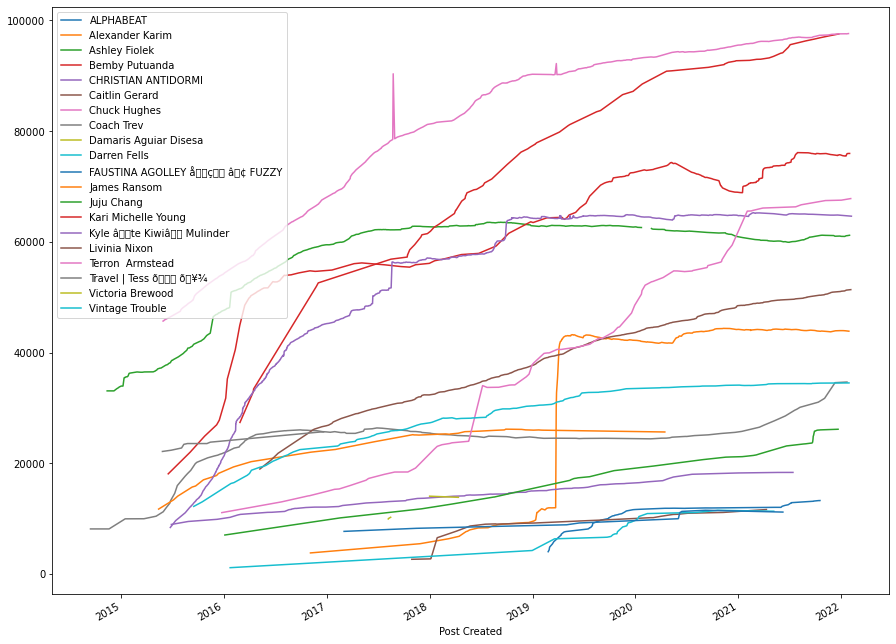

In [25]:
%matplotlib inline
random20_data = random20.loc[:,['Followers at Posting','Account','Post Created']]
random20_data['Post Created'] = pd.to_datetime(random20_data['Post Created'])
random20_data = random20_data.set_index('Post Created')
fig, ax = plt.subplots(figsize=(15,12))
random20_data.groupby('Account')['Followers at Posting'].plot(legend=True,ax=ax)

#### Focus on accounts encounter null

In [26]:
account_encounter_null = np.unique(random20[random20['Followers at Posting'].isnull()]['Account'])
account_encounter_null

array(['Ashley Fiolek', 'CHRISTIAN ANTIDORMI', 'Chuck Hughes',
       'Coach Trev', 'Damaris Aguiar Disesa',
       'FAUSTINA AGOLLEY å\x88\x98ç\x8e\x89 â\x80¢ FUZZY', 'James Ransom',
       'Juju Chang', 'Kari Michelle Young',
       'Kyle â\x80\x9cte Kiwiâ\x80\x9d Mulinder', 'Terron  Armstead',
       'Travel | Tess ð\x9f\x8c\x8f ð\x9f¥¾'], dtype=object)

Account
Ashley Fiolek                        AxesSubplot(0.125,0.2;0.775x0.68)
CHRISTIAN ANTIDORMI                  AxesSubplot(0.125,0.2;0.775x0.68)
Chuck Hughes                         AxesSubplot(0.125,0.2;0.775x0.68)
Coach Trev                           AxesSubplot(0.125,0.2;0.775x0.68)
Damaris Aguiar Disesa                AxesSubplot(0.125,0.2;0.775x0.68)
FAUSTINA AGOLLEY åç â¢ FUZZY    AxesSubplot(0.125,0.2;0.775x0.68)
James Ransom                         AxesSubplot(0.125,0.2;0.775x0.68)
Juju Chang                           AxesSubplot(0.125,0.2;0.775x0.68)
Kari Michelle Young                  AxesSubplot(0.125,0.2;0.775x0.68)
Kyle âte Kiwiâ Mulinder          AxesSubplot(0.125,0.2;0.775x0.68)
Terron  Armstead                     AxesSubplot(0.125,0.2;0.775x0.68)
Travel | Tess ð ð¥¾              AxesSubplot(0.125,0.2;0.775x0.68)
Name: Followers at Posting, dtype: object

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 136 (\x88) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 152 (\x98) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 142 (\x8e) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 137 (\x89) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128 (\x80) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 156 (\x9c) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 157 (\x9d) missing from current f

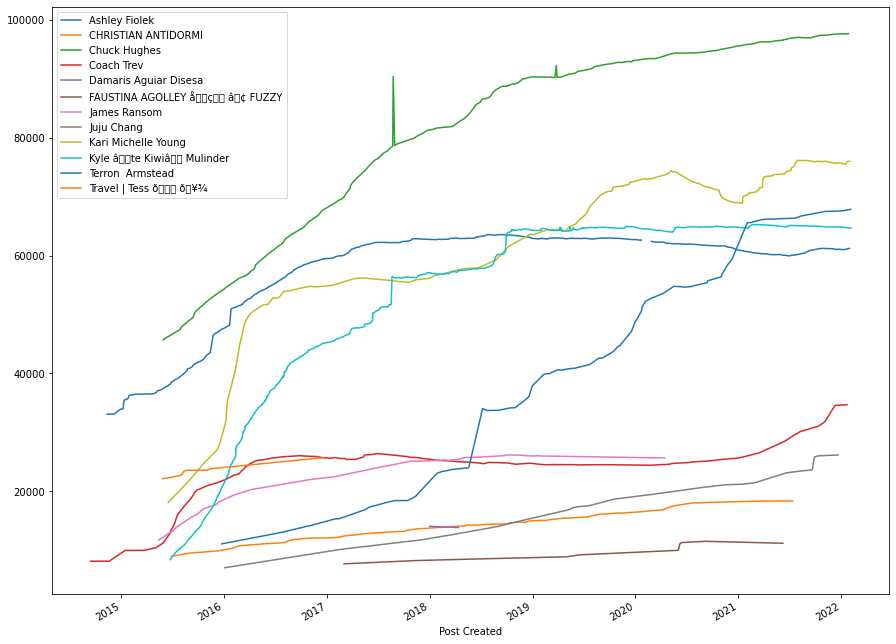

In [27]:
%matplotlib inline
random20_data = random20.loc[random20.Account.isin(account_encounter_null),['Followers at Posting','Account','Post Created']]
random20_data['Post Created'] = pd.to_datetime(random20_data['Post Created'])
random20_data = random20_data.set_index('Post Created')
fig, ax = plt.subplots(figsize=(15,12))
random20_data.groupby('Account')['Followers at Posting'].plot(legend=True,ax=ax)

Consider followers is our target variable, we should consider simply drop records encountering NA values.

In [28]:
instagram_data = instagram_data[~instagram_data['Followers at Posting'].isnull()]

In [29]:
instagram_data.shape

(256140, 20)

In [30]:
instagram_data.isnull().sum()

Account                                                       0
User Name                                                     0
Followers at Posting                                          0
Post Created                                                  0
Type                                                          0
Total Interactions                                            0
Likes                                                         0
Comments                                                      0
Views                                                         0
Like and View Counts Disabled                                 0
Photo                                                         4
Description                                                4513
Image Text                                               248577
Total Interactions (weighted on likes 1x Comments 1x)         0
Overperforming Score                                          0
PostCreatedYear                         

### Handle Text Variable

Photo is a photo link url. 

In [31]:
instagram_data[instagram_data.Photo.isnull()]

,Account,User Name,Followers at Posting,Post Created,Type,Total Interactions,Likes,Comments,Views,Like and View Counts Disabled,Photo,Description,Image Text,Total Interactions (weighted on likes 1x Comments 1x),Overperforming Score,PostCreatedYear,PostCreatedMonth,PostCreatedDay,PostCreatedHour,is_linked
24445,Aj Ramos,theajramos,35619.0,2017-09-25 03:26:30-04:00,Album,3495,3413,82,10209,False,NaN,It was around this time I told last year (2:50...,NaN,3495,2.05,2017,9,0,3,1
57899,veÌriteÌ,verite,48463.0,2021-04-20 14:50:02-04:00,Photo,2299,2229,70,0,False,NaN,my essence captured in one photo.\ni am a brok...,NaN,2299,1.22,2021,4,1,14,1
249923,slothrust,slothrust,24418.0,2021-07-23 14:34:34-04:00,Album,886,866,20,4152,False,NaN,VERY pleased to have our unreleased song âA ...,NaN,886,-1.57,2021,7,4,14,1
282454,Nathan Foley,nathanfoleyofficial,13781.0,2019-08-28 03:02:45-04:00,Album,795,740,55,4910,False,NaN,Our Highlighted Wedding Video â¤ï¸ SWIPE LEF...,NaN,795,2.56,2019,8,2,3,1


Due to the characteristics of Instagram, a post has to come with a image/vedio. In this case, we assume the image link is lost, all of the posts has 'Photo' available. We simply drop this column as it's not related to our study.

In [32]:
instagram_data = instagram_data.drop('Photo',axis=1)

### Assign Sentiment Score and Attach Descriptive Info to Text columns.
We have two of these columns to transform: Description and Image Text

#### Clean Text: Remove stopwords, tokenized and lemmatization

In [33]:
instagram_data['Description'] = instagram_data['Description'].str.strip()

In [34]:
def remove_unprintable_char(s):
    new_s = re.sub(r'[^a-zA-Z0-9\._-]', ' ', s)
    return new_s.strip()

In [35]:
instagram_data['Description'] = instagram_data['Description'].apply(str).map(remove_unprintable_char)

In [36]:
def process_description(text):
    if not pd.isnull(text):
        # tokenize 
        tags = nltk.pos_tag(word_tokenize(text))
        #Import the english stop words list from NLTK
        stopwords_english = stopwords.words('english') 

        #Creating a list of words without stopwords
        pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
        desc_clean = []
        for word, tag in tags:
            if word not in stopwords_english and word not in string.punctuation:
                desc_clean.append(tuple([word.lower(), pos_dict.get(tag[0])]))

        #Instantiate stemming class
        lemmatizer = WordNetLemmatizer()

        #Creating a list of stems of words 
        lemma_desc = ""
        for clean_word, pos in desc_clean:
            if not pos:
                lemma = clean_word
                lemma_desc = lemma_desc + " " + lemma
            else:
                lemma = lemmatizer.lemmatize(clean_word, pos=pos)
                lemma_desc = lemma_desc + " " + lemma
    else:
        lemma_desc = ''
    return lemma_desc

In [37]:
instagram_data['Description_lemma'] = instagram_data['Description'].apply(process_description)

#### Sentiment and subjective score

In [38]:
def datablob(lemma):
    return TextBlob(lemma).sentiment

In [39]:
instagram_data['Description_senti'] = instagram_data['Description_lemma'].apply(datablob)

In [40]:
instagram_data['Description_sentiment'] = np.where(instagram_data['Description_senti'].str[0]>0,'Positive','Negative')
instagram_data['Description_subjective'] = np.where(instagram_data['Description_senti'].str[1]>0.5,'Subjective','Objective')

In [41]:
instagram_data['Description_sentiment_score'] = instagram_data['Description_senti'].str[0]
instagram_data['Description_subjective_score'] = instagram_data['Description_senti'].str[1]

#### Descriptive info
Potentially we can look into how many characteristics/capital letters were used

In [42]:
instagram_data['Description_len'] =  instagram_data['Description'].str.len().fillna(0)

In [43]:
instagram_data = instagram_data.drop(['Description_lemma','Description_senti'],axis=1)

In [44]:
instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type',
       'Total Interactions', 'Likes', 'Comments', 'Views',
       'Like and View Counts Disabled', 'Description', 'Image Text',
       'Total Interactions (weighted on likes 1x Comments 1x)',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_sentiment', 'Description_subjective',
       'Description_sentiment_score', 'Description_subjective_score',
       'Description_len'],
      dtype='object')

### Understand and process Image Text

In [45]:
instagram_data[~instagram_data['Image Text'].isnull()]['Image Text']

31                                    JUNE PART PARTTWO TWO
89              REBECCA FERGUSON LADY JESSICA TUNE ITBEGINS
112                     KATHLEEN WILLEY WHITE HOUSE STAFF W
116       TIMOTHÃE REBECCA OSCAR STELLAN STEPHEN CHANG ...
167       Governor Jay Inslee @GovInslee I cannot expres...
                                ...                        
299436                                    BLACKWIDOW KILLER
299548                                     à´¤ LackTraviata
299643    Announcing our 2021 festival line-up! MAGICCIT...
299647    ** JANUARY 13 2015 RYMAN AUDITORIUM ASHVILLE*T...
299949    MY 2019 GREAT NORDEEN XC RACE RECAP 30K & 90 M...
Name: Image Text, Length: 7563, dtype: object

Image Text has different forms, some of them have comments, some of them act more like a image title. In this case we extract only descriptive information from this attribute.

In [46]:
instagram_data['Image Text'] = instagram_data['Image Text'].str.strip()
instagram_data['Image_Text_len'] = instagram_data['Image Text'].str.len().fillna(0)

In [47]:
instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type',
       'Total Interactions', 'Likes', 'Comments', 'Views',
       'Like and View Counts Disabled', 'Description', 'Image Text',
       'Total Interactions (weighted on likes 1x Comments 1x)',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_sentiment', 'Description_subjective',
       'Description_sentiment_score', 'Description_subjective_score',
       'Description_len', 'Image_Text_len'],
      dtype='object')

### Encoding Account
Potentially could be transformed via entity embedding using fastai. For time and complexity consideration we will stick with traditional target encoding.

In [48]:
len(np.unique(instagram_data['Account']))

1271

In [49]:
len(np.unique(instagram_data['User Name']))

1272

Account and User Name is roughly 1-1.

In [50]:
account_effect_lookup = instagram_data.groupby('Account')['Followers at Posting'].mean().reset_index().rename(columns={"Followers at Posting":"account_effect"})

In [51]:
account_effect_lookup

,Account,account_effect
0,#payphoneography,71660.024390
1,/ johan,27914.571429
2,A Great Big World,53350.181818
3,A L E X A N D E R W R A I T H,55983.400000
4,A L I Y A H â¥ï¸ O â B R I E N,10738.147059
...,...,...
1266,ðð¦Meganð¦ð,16452.450000
1267,ð· Adeline Gressin âï¸,12218.400000
1268,ð¥Kenjon Barnerð¥,69078.000000
1269,ð· MISS BETTY ROSEð·,44182.613718


In [52]:
instagram_data = instagram_data.merge(account_effect_lookup, on = 'Account', how='left')

Note the unprintable characters also exists in Account column.

In [53]:
instagram_data['Account'] = instagram_data['Account'].apply(remove_unprintable_char)

### Encode Type

In [54]:
np.unique(instagram_data['Type'])

array(['Album', 'Photo', 'Video'], dtype=object)

In [55]:
instagram_data['Type_cate'] = instagram_data.loc[:,'Type'].astype("category").cat.codes

In [268]:
instagram_data.loc[:,'Type'].astype("category").cat.categories

Index(['Album', 'Photo', 'Video'], dtype='object')

In [56]:
instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type',
       'Total Interactions', 'Likes', 'Comments', 'Views',
       'Like and View Counts Disabled', 'Description', 'Image Text',
       'Total Interactions (weighted on likes 1x Comments 1x)',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_sentiment', 'Description_subjective',
       'Description_sentiment_score', 'Description_subjective_score',
       'Description_len', 'Image_Text_len', 'account_effect', 'Type_cate'],
      dtype='object')

In [57]:
instagram_data.shape

(256140, 27)

## Anormaly Detection
https://towardsdatascience.com/isolation-forest-with-statistical-rules-4dd27dad2da9#:~:text=Now%20lets%20see%20what%20is%20the%20role%20of%20contamination%20parameter%20here.&text=Isolation%20forest%20separates%20each%20point,inliers%20appear%20in%20higher%20depth.

In [95]:
def iqr_bounds(scores,k=1.5):
    np_scores = np.array(scores)
    q1 = np.quantile(np_scores,0.25)
    q3 = np.quantile(np_scores,0.75)
    iqr = q3 - q1
    lower_bound=(q1 - k * iqr)
    upper_bound=(q3 + k * iqr)
    return lower_bound,upper_bound

def isolation_forest_anomaly(data, time_var, group_var, target, ratio = 0.05):
    groups = np.unique(data[group_var])
    survived_df = pd.DataFrame()
    detected_df = pd.DataFrame()
    for data_group in groups:
        group_data = data[data[group_var] == data_group]
        ts_data = group_data.sort_values(time_var)[[time_var,target]].set_index(time_var)
        iforest = IsolationForest(contamination=ratio)
        pred = iforest.fit_predict(ts_data.values)
        
        score = iforest.decision_function(ts_data[[target]].values)
        ts_data['IsolationForestPred'] = pred
        ts_data['IsolationForestScore'] = score
        anomaly_selected = ts_data[ts_data.IsolationForestPred==-1]
        survived_data = ts_data[ts_data.IsolationForestPred!=-1]
        
        # Apply quantile bounds to exclude changes in accetable range out of Isolation Forest index list
        lower_bound,upper_bound=iqr_bounds(list(score),k=2)
        ts_data['IQR_Adapted'] = np.where(ts_data['IsolationForestScore'] < lower_bound, 1, np.where(ts_data['IsolationForestScore'] > upper_bound, 1, 0))
        survived_from_IQR = ts_data[ts_data.IQR_Adapted==0]
        final_survived_data = pd.concat([survived_data,survived_from_IQR]).reset_index()
        final_survived_dates = final_survived_data.loc[:,time_var]
        group_data_servived = group_data[group_data[time_var].isin(final_survived_dates)]
        group_data_detected = group_data[~group_data[time_var].isin(final_survived_dates)]
        survived_df = pd.concat([survived_df,group_data_servived])
        detected_df = pd.concat([detected_df,group_data_detected])
    survived_df['anomaly_ind'] = 0
    detected_df['anomaly_ind'] = 1
    final_df = pd.concat([survived_df,detected_df]).sort_index()
    return final_df
    #return survived_df,detected_df

In [96]:
instagram_data_anormaly_detected = isolation_forest_anomaly(instagram_data, 'Post Created', 'User Name', 'Followers at Posting')

In [97]:
instagram_data_anormaly_detected.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type',
       'Total Interactions', 'Likes', 'Comments', 'Views',
       'Like and View Counts Disabled', 'Description', 'Image Text',
       'Total Interactions (weighted on likes 1x Comments 1x)',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_sentiment', 'Description_subjective',
       'Description_sentiment_score', 'Description_subjective_score',
       'Description_len', 'Image_Text_len', 'account_effect', 'Type_cate',
       'anomaly_ind'],
      dtype='object')

In [99]:
instagram_data_anormaly_detected.shape

(256140, 28)

In [254]:
data = pd.read_sql("select * from ins_account_data",con=connection_engine)
data

2022-04-11 06:14:43,449 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


INFO:sqlalchemy.engine.Engine:SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


2022-04-11 06:14:43,451 INFO sqlalchemy.engine.Engine [cached since 2.144e+05s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_account_data'}


INFO:sqlalchemy.engine.Engine:[cached since 2.144e+05s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_account_data'}


2022-04-11 06:14:43,583 INFO sqlalchemy.engine.Engine select * from ins_account_data


INFO:sqlalchemy.engine.Engine:select * from ins_account_data


2022-04-11 06:14:43,585 INFO sqlalchemy.engine.Engine [raw sql] {}


INFO:sqlalchemy.engine.Engine:[raw sql] {}


,index,Account,User Name,Followers at Posting,Post Created,Type,Total Interactions,Likes,Comments,Views,...,Description_subjective_score,Description_len,Image_Text_len,account_effect,Type_cate,anomaly_ind,Followers_at_Posting_pct_change,Total_Interactions_pct_change,Likes_pct_change,Comments_pct_change
0,0,Rebecca Ferguson,officialrebeccaferguson,404268.0,2021-10-17 13:29:58,Album,104703,104238,465,0,...,0.000000,76,0.0,297234.538462,0,0,0.000000,1.457702,1.458849,1.224880
1,1,Rebecca Ferguson,officialrebeccaferguson,490753.0,2021-11-15 11:42:52,Album,102836,102426,410,0,...,0.500000,150,0.0,297234.538462,0,0,0.007748,1.397557,1.404536,0.389831
2,2,Rebecca Ferguson,officialrebeccaferguson,472941.0,2021-11-04 17:52:59,Photo,101672,101230,442,0,...,0.000000,29,0.0,297234.538462,1,0,0.021158,0.468803,0.467208,0.955752
3,3,Rebecca Ferguson,officialrebeccaferguson,333044.0,2021-08-06 16:40:38,Photo,99049,97849,1200,0,...,0.900000,141,0.0,297234.538462,1,0,0.001022,4.777473,4.745347,9.619469
4,4,Rebecca Ferguson,officialrebeccaferguson,533227.0,2021-12-31 15:39:14,Album,98218,97230,988,0,...,0.694444,85,0.0,297234.538462,0,0,0.002787,1.441169,1.431479,3.016260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256135,256135,Travel Blogger Revati Charles,differentdoors,29898.0,2019-08-04 01:10:06,Photo,747,738,9,0,...,0.533333,1139,0.0,22904.099822,1,0,-0.000668,-0.350435,-0.352063,-0.181818
256136,256136,marcvetri,marcvetri,39603.0,2017-08-25 18:56:00,Photo,747,729,18,0,...,0.400000,109,0.0,59085.961818,1,0,0.000632,-0.201070,-0.205016,0.000000
256137,256137,Max Eli,thesussmans,12670.0,2019-03-28 10:21:22,Photo,747,731,16,0,...,0.437698,1877,0.0,21546.686441,1,0,0.005316,-0.191558,-0.205435,3.000000
256138,256138,Kit Lee,itskitlee,44012.0,2017-11-25 08:52:37,Photo,747,734,13,0,...,0.439177,1002,0.0,36941.444277,1,0,0.000205,-0.122209,-0.125149,0.083333


In [286]:
#anomaly_data = data[data['anomaly_ind']==1]
data_summary = (data.groupby("User Name")[['index','anomaly_ind']]
 .agg({'index':'count','anomaly_ind':'sum'})
 .rename(columns={'index':'post_count','anomaly_ind':'count_of_anomaly_datapoints'})
 .reset_index())
data_summary['anomaly_pct'] = data_summary['count_of_anomaly_datapoints']/data_summary['post_count']
anormaly_accounts = data_summary[data_summary['anomaly_pct']>=0.1].sort_values(by='anomaly_pct',ascending=False)

## Post-over-post followers delta in percentage

In [289]:
deltas_pct_summary = (instagram_data_anormaly_detected
                      .sort_values(['User Name','Post Created'])
                      .groupby(['User Name'])[['Followers at Posting','Total Interactions','Likes','Comments']]#'User Name','Post Created',
                      .pct_change())
deltas_pct_summary.columns = ['Followers_at_Posting_pct_change','Total_Interactions_pct_change','Likes_pct_change','Comments_pct_change']
instagram_data_deltas_summary = (instagram_data_anormaly_detected
                                 .join(deltas_pct_summary)
                                 .sort_index())
instagram_data_deltas_summary = instagram_data_deltas_summary.replace([np.inf, -np.inf], np.nan)

### Data check point 1

In [242]:
transformed_instagram_data.to_csv('ins_account_data.csv')

In [5]:
user = "admin"
password = "tuIzaqrAKLMe32G0"
host = "instagram-data-db.csik1hfjt1qb.us-east-1.rds.amazonaws.com"
port = 3306
db = "instagram_data"
connection_engine = sqlalchemy.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + str(port) + '/' + db , echo=True)

In [290]:
instagram_data_deltas_summary.to_sql(con=connection_engine, name='ins_account_data', if_exists='replace', index=True) #.fillna(-99999)

2022-04-08 05:19:51,757 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 05:19:51,758 INFO sqlalchemy.engine.Engine [cached since 3268s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data'}
2022-04-08 05:19:51,948 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 05:19:51,948 INFO sqlalchemy.engine.Engine [cached since 3268s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data'}
2022-04-08 05:19:52,137 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `instagram_data`
2022-04-08 05:19:52,137 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-08 05:19:52,203 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `ins_account_data`
2022-04-08 05:19:52,204 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-08 05:19:52,338 INFO sqlalchemy.engi

In [246]:
select_text_data = text_data.loc[instagram_data_deltas_summary.index,:]
select_text_data.to_csv('ins_text_data.csv')
select_text_data.to_sql(con=connection_engine, name='ins_text_data', if_exists='replace', index=True)

2022-04-08 04:29:48,777 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 04:29:48,778 INFO sqlalchemy.engine.Engine [cached since 264.7s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_text_data'}
2022-04-08 04:29:48,976 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 04:29:48,977 INFO sqlalchemy.engine.Engine [cached since 264.9s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_text_data'}
2022-04-08 04:29:49,167 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `instagram_data`
2022-04-08 04:29:49,168 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-08 04:29:49,238 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `ins_text_data`
2022-04-08 04:29:49,239 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-08 04:29:49,412 INFO sqlalchemy.engine.Engi

## Pandas Profiling

In [160]:
profile = ProfileReport(instagram_data_deltas_summary, title="Pandas Profiling Report", correlations=None, interactions={'continuous': False}, explorative=False)
profile.to_file(output_file="data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

We noticed 'Like and View Counts Disabled' is unary after we remove problematic rows.

## Correlation matrix for Account&post data (except LIWC2015 text data)

In [163]:
instagram_data_sql = pd.read_sql('select * from ins_account_data',con=connection_engine)

2022-04-08 00:36:49,671 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 00:36:49,672 INFO sqlalchemy.engine.Engine [cached since 1662s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_account_data'}
2022-04-08 00:36:49,799 INFO sqlalchemy.engine.Engine select * from ins_account_data
2022-04-08 00:36:49,800 INFO sqlalchemy.engine.Engine [raw sql] {}


In [164]:
corr = instagram_data_sql.corr()
corr.style.background_gradient(cmap='coolwarm')

,index,Followers at Posting,Total Interactions,Likes,Comments,Views,Like and View Counts Disabled,Total Interactions (weighted on likes 1x Comments 1x),Overperforming Score,PostCreatedYear,PostCreatedMonth,PostCreatedDay,PostCreatedHour,is_linked,Description_sentiment_score,Description_subjective_score,Description_len,Image_Text_len,account_effect,Type_cate,anomaly_ind,Followers_at_Posting_pct_change,Total_Interactions_pct_change,Likes_pct_change,Comments_pct_change
index,1.000000,-0.272367,-0.556552,-0.553438,-0.221729,-0.044155,nan,-0.556552,-0.218247,-0.138588,-0.007571,0.003940,-0.006014,-0.014575,0.002213,-0.000421,-0.013637,-0.006560,-0.194523,0.059954,0.051798,-0.041972,-0.042021,-0.042021,-0.039238
Followers at Posting,-0.272367,1.000000,0.372014,0.376238,0.041858,0.015605,nan,0.372014,0.014562,0.160178,0.008511,-0.003711,-0.011286,-0.002537,0.001390,0.001226,0.019167,0.015452,0.852383,-0.013796,-0.073827,0.070722,0.070727,0.070727,0.044933
Total Interactions,-0.556552,0.372014,1.000000,0.998433,0.330469,0.086273,nan,1.000000,0.267380,0.130513,0.012320,-0.006665,0.004576,0.007259,-0.006757,-0.007025,0.004186,0.007607,0.304983,-0.054821,-0.001381,0.016700,0.016750,0.016750,0.015590
Likes,-0.553438,0.376238,0.998433,1.000000,0.277134,0.084281,nan,0.998433,0.255629,0.125974,0.012783,-0.005634,0.003794,0.007034,-0.007076,-0.008413,0.000399,0.005422,0.309812,-0.056701,-0.002353,0.017381,0.017430,0.017430,0.015552
Comments,-0.221729,0.041858,0.330469,0.277134,1.000000,0.059832,nan,0.330469,0.279484,0.116238,-0.004069,-0.019409,0.014581,0.005991,0.003328,0.021258,0.065145,0.039153,0.011282,0.015042,0.015971,-0.006409,-0.006381,-0.006385,0.005370
Views,-0.044155,0.015605,0.086273,0.084281,0.059832,1.000000,nan,0.086273,0.152370,0.025332,-0.003101,0.001332,0.002325,0.001158,-0.005170,-0.000515,-0.000912,-0.004218,0.009728,0.115375,0.000749,0.002292,0.002305,0.002304,0.003008
Like and View Counts Disabled,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Total Interactions (weighted on likes 1x Comments 1x),-0.556552,0.372014,1.000000,0.998433,0.330469,0.086273,nan,1.000000,0.267380,0.130513,0.012320,-0.006665,0.004576,0.007259,-0.006757,-0.007025,0.004186,0.007607,0.304983,-0.054821,-0.001381,0.016700,0.016750,0.016750,0.015590
Overperforming Score,-0.218247,0.014562,0.267380,0.255629,0.279484,0.152370,nan,0.267380,1.000000,0.065969,-0.001982,-0.002549,0.004428,0.008685,0.006280,0.016041,0.053145,0.012027,-0.051470,0.077646,-0.000731,-0.018229,-0.018178,-0.018180,-0.013841
PostCreatedYear,-0.138588,0.160178,0.130513,0.125974,0.116238,0.025332,nan,0.130513,0.065969,1.000000,-0.127280,-0.015727,0.011204,0.010482,0.020541,0.050835,0.145780,0.121830,-0.143789,-0.143665,-0.074410,0.073728,0.073736,0.073736,0.065903


# Monthly Data Transformation

Drop columns that are not using for next step.

In [166]:
print(list(instagram_data_sql.columns))

['index', 'Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type', 'Total Interactions', 'Likes', 'Comments', 'Views', 'Like and View Counts Disabled', 'Description', 'Image Text', 'Total Interactions (weighted on likes 1x Comments 1x)', 'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth', 'PostCreatedDay', 'PostCreatedHour', 'is_linked', 'Description_sentiment', 'Description_subjective', 'Description_sentiment_score', 'Description_subjective_score', 'Description_len', 'Image_Text_len', 'account_effect', 'Type_cate', 'anomaly_ind', 'Followers_at_Posting_pct_change', 'Total_Interactions_pct_change', 'Likes_pct_change', 'Comments_pct_change', 'cvfold']


In [195]:
instagram_data_sql['Description_pos_sentiment'] = np.where(instagram_data_sql['Description_sentiment']=='Positive',1,0)
instagram_data_sql['Description_subjective'] = np.where(instagram_data_sql['Description_subjective']=='Subjective',1,0)

In [198]:
ins_account_input = instagram_data_sql.drop(['Account','Post Created','Type','Likes',
                                             'Total Interactions (weighted on likes 1x Comments 1x)',
                                             'Description', 'Image Text','Description_sentiment',
                                             'Description_sentiment_score', 'Description_subjective_score',
                                             'Followers_at_Posting_pct_change', 'Total_Interactions_pct_change', 
                                             'Likes_pct_change', 'Comments_pct_change', 'cvfold'
                                             ],axis=1)

In [199]:
ins_account_input.columns

Index(['index', 'User Name', 'Followers at Posting', 'Total Interactions',
       'Comments', 'Views', 'Like and View Counts Disabled',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_subjective', 'Description_len', 'Image_Text_len',
       'account_effect', 'Type_cate', 'anomaly_ind',
       'Description_pos_sentiment'],
      dtype='object')

In [205]:
ins_account_input = ins_account_input[ins_account_input['anomaly_ind']==0].drop('anomaly_ind',axis=1)
ins_account_input.shape

(250707, 19)

## Monthly data

In [253]:
monthly = (ins_account_input
           .sort_values(['User Name','PostCreatedYear','PostCreatedMonth'])
           .groupby(['User Name','PostCreatedYear','PostCreatedMonth'])
           #[['User Name','PostCreatedYear','PostCreatedMonth','Followers at Posting','Total Interactions','Comments']]
           #.pct_change()
           .agg({'Followers at Posting':['last','max',"var","count"],
                 'Total Interactions':['median','max',"var"],
                 'Comments':['median','max',"var"],
                 'Views':['median','max','var'],
                 'Overperforming Score':['median','max','var'],
                 'Description_subjective':['sum'],
                 'Description_pos_sentiment':['sum'],
                 'is_linked':['sum'],
                 'Description_len':['median','max'],
                 'Image_Text_len':['median','max'],
                 'Type_cate':['median']
                 }))
monthly.columns = [' - '.join(list(x)) for x in list(monthly.columns)]

In [254]:
monthly_data = monthly.reset_index().fillna(0)

In [255]:
monthly_data = monthly_data.rename(columns={'Followers at Posting - count':'post_count'})

In [256]:
monthly_data.columns

Index(['User Name', 'PostCreatedYear', 'PostCreatedMonth',
       'Followers at Posting - last', 'Followers at Posting - max',
       'Followers at Posting - var', 'post_count',
       'Total Interactions - median', 'Total Interactions - max',
       'Total Interactions - var', 'Comments - median', 'Comments - max',
       'Comments - var', 'Views - median', 'Views - max', 'Views - var',
       'Overperforming Score - median', 'Overperforming Score - max',
       'Overperforming Score - var', 'Description_subjective - sum',
       'Description_pos_sentiment - sum', 'is_linked - sum',
       'Description_len - median', 'Description_len - max',
       'Image_Text_len - median', 'Image_Text_len - max',
       'Type_cate - median'],
      dtype='object')

In [257]:
monthly_data['Description_subjective_pct'] = monthly_data['Description_subjective - sum']/monthly_data['post_count']
monthly_data['Description_pos_sentiment_pct'] = monthly_data['Description_pos_sentiment - sum']/monthly_data['post_count']
monthly_data['is_linked_pct'] = monthly_data['is_linked - sum']/monthly_data['post_count']

### Save to SQL

In [258]:
monthly_data.to_sql(con=connection_engine, name='ins_account_data_monthly', if_exists='replace', index=True)

2022-04-08 04:50:23,399 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 04:50:23,400 INFO sqlalchemy.engine.Engine [cached since 1499s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data_monthly'}
2022-04-08 04:50:23,589 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 04:50:23,590 INFO sqlalchemy.engine.Engine [cached since 1500s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data_monthly'}
2022-04-08 04:50:23,779 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `instagram_data`
2022-04-08 04:50:23,780 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-08 04:50:23,844 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `ins_account_data_monthly`
2022-04-08 04:50:23,845 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-08 04:50:23,

## Monthly summary data for text data

In [70]:
text_raw = pd.read_sql("""select *, year(`Post Created`) as PostCreatedYear, month(`Post Created`) as PostCreatedMonth  from ins_text_data as A
join (select `index` as account_index,`User Name`,`Post Created` from ins_account_data) as B 
on A.`index` = B.account_index""",con=connection_engine)

2022-04-08 19:53:50,001 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


INFO:sqlalchemy.engine.Engine:SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


2022-04-08 19:53:50,003 INFO sqlalchemy.engine.Engine [cached since 4355s ago] {'table_schema': 'instagram_data', 'table_name': 'select *, year(`Post Created`) as PostCreatedYear, month(`Post Created`) as PostCreatedMonth  from ins_text_data as A\njoin (select `index` as account_index,`User Name`,`Post Created` from ins_account_data) as B \non A.`index` = B.account_index'}


INFO:sqlalchemy.engine.Engine:[cached since 4355s ago] {'table_schema': 'instagram_data', 'table_name': 'select *, year(`Post Created`) as PostCreatedYear, month(`Post Created`) as PostCreatedMonth  from ins_text_data as A\njoin (select `index` as account_index,`User Name`,`Post Created` from ins_account_data) as B \non A.`index` = B.account_index'}


2022-04-08 19:53:50,132 INFO sqlalchemy.engine.Engine select *, year(`Post Created`) as PostCreatedYear, month(`Post Created`) as PostCreatedMonth  from ins_text_data as A
join (select `index` as account_index,`User Name`,`Post Created` from ins_account_data) as B 
on A.`index` = B.account_index


INFO:sqlalchemy.engine.Engine:select *, year(`Post Created`) as PostCreatedYear, month(`Post Created`) as PostCreatedMonth  from ins_text_data as A
join (select `index` as account_index,`User Name`,`Post Created` from ins_account_data) as B 
on A.`index` = B.account_index


2022-04-08 19:53:50,133 INFO sqlalchemy.engine.Engine [raw sql] {}


INFO:sqlalchemy.engine.Engine:[raw sql] {}


In [71]:
monthly_text_processed = text_raw.drop(['Post Created','account_index','index'],axis=1)
monthly_text_fin = (monthly_text_processed.groupby(['User Name','PostCreatedYear','PostCreatedMonth'])
                    .agg("mean")
                    .reset_index())
monthly_text_fin

,User Name,PostCreatedYear,PostCreatedMonth,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,35_fitz,2015,1,209.000000,63.090,98.720000,19.270000,99.000000,26.120000,21.530000,...,10.530000,0.000,0.0,0.000000,0.000000,0.000,0.000000,1.440000,2.39,0.960000
1,35_fitz,2015,2,4.000000,93.260,99.000000,1.000000,25.770000,2.000000,25.000000,...,0.000000,0.000,0.0,0.000000,50.000000,0.000,0.000000,0.000000,0.00,25.000000
2,35_fitz,2015,5,1.000000,93.260,50.000000,1.000000,25.770000,1.000000,100.000000,...,0.000000,0.000,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.00,100.000000
3,35_fitz,2015,12,27.500000,91.025,64.180000,70.550000,94.745000,6.250000,43.380000,...,1.960000,0.000,0.0,0.000000,0.980000,0.000,0.000000,0.000000,0.00,26.960000
4,35_fitz,2016,1,36.666667,67.460,64.296667,27.486667,35.426667,7.916667,17.950000,...,4.026667,0.000,0.0,1.846667,10.283333,1.540,3.333333,1.666667,0.00,5.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48017,zzward,2021,10,45.000000,73.938,74.160000,32.716000,81.666000,10.708000,20.234000,...,1.342000,0.000,0.0,0.000000,0.496000,0.166,0.000000,0.564000,0.33,23.286000
48018,zzward,2021,11,27.000000,74.330,73.260000,1.000000,25.770000,9.915000,40.275000,...,0.000000,4.650,0.0,0.000000,18.180000,0.000,0.000000,0.000000,0.00,37.840000
48019,zzward,2021,12,45.333333,98.660,65.696667,29.290000,50.180000,12.066667,29.253333,...,8.223333,2.380,0.0,0.000000,0.286667,3.530,2.380000,3.243333,0.00,8.006667
48020,zzward,2022,1,27.000000,64.548,50.532000,44.664000,51.022000,8.884000,11.566000,...,2.292000,1.202,0.0,0.000000,1.580000,0.000,1.026000,3.132000,0.00,2.000000


## Deltas based on monthly data

In [152]:
pd.read_sql("show tables",con=connection_engine)

ERROR:sqlalchemy.pool.impl.QueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pymysql/connections.py", line 756, in _write_bytes
    self._sock.sendall(data)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "/opt/conda/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "/opt/conda/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 682, in do_rollback
    dbapi_connection.rollback()
  File "/opt/conda/lib/python3.7/site-packages/pymysql/connections.py", line 479, in rollback
    self._execute_command(COMMAND.COM_QUERY, "ROLLBACK")
  File "/opt/conda/lib/python3.7/site-packages/pymysql/connections.py", line 814, 

2022-04-10 04:23:48,122 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


INFO:sqlalchemy.engine.Engine:SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


2022-04-10 04:23:48,123 INFO sqlalchemy.engine.Engine [cached since 1.214e+05s ago] {'table_schema': 'instagram_data', 'table_name': 'show tables'}


INFO:sqlalchemy.engine.Engine:[cached since 1.214e+05s ago] {'table_schema': 'instagram_data', 'table_name': 'show tables'}


2022-04-10 04:23:48,261 INFO sqlalchemy.engine.Engine show tables


INFO:sqlalchemy.engine.Engine:show tables


2022-04-10 04:23:48,262 INFO sqlalchemy.engine.Engine [raw sql] {}


INFO:sqlalchemy.engine.Engine:[raw sql] {}


,Tables_in_instagram_data
0,ins_account_data
1,ins_account_data_account_lv
2,ins_account_data_account_lv_text
3,ins_account_data_monthly
4,ins_data_model_input
5,ins_text_data


In [12]:
 monthly_data = pd.read_sql("select * from ins_account_data_monthly",con=connection_engine).set_index("index")

2022-04-08 18:42:58,143 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 18:42:58,144 INFO sqlalchemy.engine.Engine [cached since 103.5s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_account_data_monthly'}
2022-04-08 18:42:58,272 INFO sqlalchemy.engine.Engine select * from ins_account_data_monthly
2022-04-08 18:42:58,273 INFO sqlalchemy.engine.Engine [raw sql] {}


In [13]:
monthly_data_delta= monthly_data.drop(['Followers at Posting - var','Total Interactions - var','Comments - var','Views - var','Overperforming Score - var',
                                        'Description_subjective - sum','Description_pos_sentiment - sum', 'is_linked - sum'],axis=1)
monthly_data_delta.columns

Index(['User Name', 'PostCreatedYear', 'PostCreatedMonth',
       'Followers at Posting - last', 'Followers at Posting - max',
       'post_count', 'Total Interactions - median', 'Total Interactions - max',
       'Comments - median', 'Comments - max', 'Views - median', 'Views - max',
       'Overperforming Score - median', 'Overperforming Score - max',
       'Description_len - median', 'Description_len - max',
       'Image_Text_len - median', 'Image_Text_len - max', 'Type_cate - median',
       'Description_subjective_pct', 'Description_pos_sentiment_pct',
       'is_linked_pct'],
      dtype='object')

In [14]:
monthly_data_delta

,User Name,PostCreatedYear,PostCreatedMonth,Followers at Posting - last,Followers at Posting - max,post_count,Total Interactions - median,Total Interactions - max,Comments - median,Comments - max,...,Overperforming Score - median,Overperforming Score - max,Description_len - median,Description_len - max,Image_Text_len - median,Image_Text_len - max,Type_cate - median,Description_subjective_pct,Description_pos_sentiment_pct,is_linked_pct
index,,,,,,,,,,,,,,,,,,,,,
0,35_fitz,2015,1,15419.0,15419.0,1,5672.0,5672,679.0,679,...,8.090,8.09,12.0,12,0.0,0.0,2.0,0.0,0.000000,1.0
1,35_fitz,2015,2,15419.0,15419.0,1,1382.0,1382,42.0,42,...,1.010,1.01,89.0,89,0.0,0.0,1.0,0.0,1.000000,1.0
2,35_fitz,2015,12,20660.0,20660.0,2,1128.0,1217,42.0,53,...,-1.215,-1.12,64.0,115,0.0,0.0,1.0,0.0,0.500000,1.0
3,35_fitz,2016,1,21556.0,21836.0,3,1049.0,1383,44.0,63,...,-1.300,1.01,40.0,103,0.0,0.0,1.0,0.0,0.333333,1.0
4,35_fitz,2016,2,23137.0,23137.0,3,1045.0,1668,22.0,37,...,-1.310,1.22,22.0,59,0.0,0.0,1.0,0.0,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45868,zzward,2021,10,58925.0,58941.0,5,1549.0,1922,24.0,76,...,-1.070,1.13,49.0,1224,0.0,0.0,1.0,0.0,0.400000,1.0
45869,zzward,2021,11,59227.0,59227.0,2,1457.0,2040,33.0,49,...,-0.330,1.23,15.5,20,0.0,0.0,1.0,0.0,0.500000,1.0
45870,zzward,2021,12,59282.0,59323.0,3,1378.0,2987,41.0,89,...,-1.200,1.80,23.0,988,0.0,0.0,1.0,0.0,0.333333,1.0


In [21]:
delta_calc = (monthly_data_delta
              .sort_values(by=['User Name','PostCreatedYear','PostCreatedMonth'])
              .drop(['PostCreatedYear','PostCreatedMonth','Type_cate - median'],axis=1)
              .groupby(['User Name'])
              .pct_change())
delta_calc.columns = [x+"_pct_change" for x in list(delta_calc.columns)]
delta = delta_calc.dropna(how='all').replace([np.inf, -np.inf], np.nan)

In [22]:
delta

,Followers at Posting - last_pct_change,Followers at Posting - max_pct_change,post_count_pct_change,Total Interactions - median_pct_change,Total Interactions - max_pct_change,Comments - median_pct_change,Comments - max_pct_change,Views - median_pct_change,Views - max_pct_change,Overperforming Score - median_pct_change,Overperforming Score - max_pct_change,Description_len - median_pct_change,Description_len - max_pct_change,Image_Text_len - median_pct_change,Image_Text_len - max_pct_change,Description_subjective_pct_pct_change,Description_pos_sentiment_pct_pct_change,is_linked_pct_pct_change
index,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,-0.756347,-0.756347,-0.938144,-0.938144,NaN,NaN,-0.875155,-0.875155,6.416667,6.416667,NaN,NaN,NaN,NaN,0.0
2,0.339905,0.339905,1.000000,-0.183792,-0.119392,0.000000,0.261905,NaN,NaN,-2.202970,-2.108911,-0.280899,0.292135,NaN,NaN,NaN,-0.500000,0.0
3,0.043369,0.056922,0.500000,-0.070035,0.136401,0.047619,0.188679,NaN,NaN,0.069959,-1.901786,-0.375000,-0.104348,NaN,NaN,NaN,-0.333333,0.0
4,0.073344,0.059581,0.000000,-0.003813,0.206074,-0.500000,-0.412698,NaN,NaN,0.007692,0.207921,-0.450000,-0.427184,NaN,NaN,NaN,1.000000,0.0
5,0.158059,0.158059,-0.666667,-0.224880,-0.514388,0.136364,-0.324324,NaN,NaN,0.282443,-2.377049,-0.500000,-0.813559,NaN,NaN,NaN,-1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45868,0.002228,0.001155,-0.166667,0.383653,-0.215830,-0.076923,0.266667,NaN,-1.0,-0.126531,-0.246667,-0.359477,4.100000,NaN,NaN,NaN,-0.200000,0.0
45869,0.005125,0.004852,-0.600000,-0.059393,0.061394,0.375000,-0.355263,NaN,NaN,-0.691589,0.088496,-0.683673,-0.983660,NaN,NaN,NaN,0.250000,0.0
45870,0.000929,0.001621,0.500000,-0.054221,0.464216,0.242424,0.816327,NaN,NaN,2.636364,0.463415,0.483871,48.400000,NaN,NaN,NaN,-0.333333,0.0


Drop columns that has too many null values.

In [17]:
delta.isnull().sum()/delta.shape[0]

Followers at Posting - last_pct_change      0.000000
Followers at Posting - max_pct_change       0.000000
post_count_pct_change                       0.000000
Total Interactions - median_pct_change      0.000000
Total Interactions - max_pct_change         0.000000
Comments - median_pct_change                0.001771
Comments - max_pct_change                   0.001682
Views - median_pct_change                   0.881169
Views - max_pct_change                      0.665434
Overperforming Score - median_pct_change    0.001278
Overperforming Score - max_pct_change       0.000000
Description_len - median_pct_change         0.006883
Description_len - max_pct_change            0.005964
Image_Text_len - median_pct_change          0.973297
Image_Text_len - max_pct_change             0.893814
Description_subjective_pct_pct_change       1.000000
Description_pos_sentiment_pct_pct_change    0.198292
is_linked_pct_pct_change                    0.000000
dtype: float64

In [18]:
delta_fin = (delta.drop(['Views - median_pct_change','Views - max_pct_change',
                        'Image_Text_len - median_pct_change','Image_Text_len - max_pct_change',
                        'Description_subjective_pct_pct_change'],axis=1)
             .fillna(0))

In [50]:
delta_fin = delta_fin.join(monthly_data_delta[['User Name','PostCreatedYear','PostCreatedMonth']])

In [53]:
delta_fin

,Followers at Posting - last_pct_change,Followers at Posting - max_pct_change,post_count_pct_change,Total Interactions - median_pct_change,Total Interactions - max_pct_change,Comments - median_pct_change,Comments - max_pct_change,Overperforming Score - median_pct_change,Overperforming Score - max_pct_change,Description_len - median_pct_change,Description_len - max_pct_change,Description_pos_sentiment_pct_pct_change,is_linked_pct_pct_change,User Name,PostCreatedYear,PostCreatedMonth
index,,,,,,,,,,,,,,,,
32,2.057072,2.057072,0.000000,-0.286848,-0.286848,-0.863034,-0.863034,-0.632880,-0.632880,10.083333,10.083333,0.000000,0.0,35_fitz,2019,4
33,-0.010353,-0.010353,0.000000,-0.673424,-0.673424,-0.720430,-0.720430,-0.542088,-0.542088,-0.421053,-0.421053,0.000000,0.0,35_fitz,2019,5
34,-0.003623,-0.003623,0.000000,-0.420893,-0.420893,-0.576923,-0.576923,-2.308824,-2.308824,0.064935,0.064935,0.000000,0.0,35_fitz,2019,6
35,0.004905,0.004905,0.000000,2.066667,2.066667,1.000000,1.000000,-1.966292,-1.966292,-0.743902,-0.743902,0.000000,0.0,35_fitz,2019,7
36,-0.004624,-0.004624,1.000000,-0.585891,-0.536232,0.545455,1.181818,-1.694767,-1.662791,5.476190,7.285714,0.000000,0.0,35_fitz,2019,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45814,-0.010038,-0.000610,0.750000,-0.164670,0.587083,-0.485294,1.070588,0.099206,0.941748,0.844444,1.684211,1.571429,0.0,zzward,2017,4
45813,-0.000617,-0.011761,0.071429,-0.063934,-0.493329,0.142857,-0.704545,0.133574,-0.325000,-0.301205,-0.568627,-0.377778,0.0,zzward,2017,3
45812,-0.124161,-0.123177,-0.466667,-0.067863,-0.036866,0.025000,-0.346154,-0.070064,0.000000,0.163793,0.967532,-0.375000,0.0,zzward,2017,2


In [57]:
delta_input = delta_fin.merge(monthly_text_fin,how='left',on=['User Name','PostCreatedYear','PostCreatedMonth'])

In [64]:
delta_input_model = delta_input.drop(['User Name'],axis=1)

### Write to SQL

In [90]:
delta_input_model.to_sql(con=connection_engine, name='ins_data_model_input', if_exists='replace', index=True)

2022-04-08 20:10:07,054 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


INFO:sqlalchemy.engine.Engine:SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


2022-04-08 20:10:07,056 INFO sqlalchemy.engine.Engine [cached since 5332s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_data_model_input'}


INFO:sqlalchemy.engine.Engine:[cached since 5332s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_data_model_input'}


2022-04-08 20:10:07,197 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-04-08 20:10:07,208 INFO sqlalchemy.engine.Engine 
CREATE TABLE ins_data_model_input (
	`index` BIGINT, 
	`Followers at Posting - last_pct_change` FLOAT(53), 
	`Followers at Posting - max_pct_change` FLOAT(53), 
	post_count_pct_change FLOAT(53), 
	`Total Interactions - median_pct_change` FLOAT(53), 
	`Total Interactions - max_pct_change` FLOAT(53), 
	`Comments - median_pct_change` FLOAT(53), 
	`Comments - max_pct_change` FLOAT(53), 
	`Overperforming Score - median_pct_change` FLOAT(53), 
	`Overperforming Score - max_pct_change` FLOAT(53), 
	`Description_len - median_pct_change` FLOAT(53), 
	`Description_len - max_pct_change` FLOAT(53), 
	`Description_pos_sentiment_pct_pct_change` FLOAT(53), 
	is_linked_pct_pct_change FLOAT(53), 
	`PostCreatedYear` SMALLINT, 
	`PostCreatedMonth` SMALLINT, 
	`WC` FLOAT(53), 
	`Analytic` FLOAT(53), 
	`Clout` FLOAT(53), 
	`Authentic` FLOAT(53), 
	`Tone` FLOAT(53), 
	`WPS` FLOAT(53), 
	`Sixltr` FLOAT(53), 
	`Dic` FLOAT(53), 
	`function` FLOAT(53), 
	pro

INFO:sqlalchemy.engine.Engine:
CREATE TABLE ins_data_model_input (
	`index` BIGINT, 
	`Followers at Posting - last_pct_change` FLOAT(53), 
	`Followers at Posting - max_pct_change` FLOAT(53), 
	post_count_pct_change FLOAT(53), 
	`Total Interactions - median_pct_change` FLOAT(53), 
	`Total Interactions - max_pct_change` FLOAT(53), 
	`Comments - median_pct_change` FLOAT(53), 
	`Comments - max_pct_change` FLOAT(53), 
	`Overperforming Score - median_pct_change` FLOAT(53), 
	`Overperforming Score - max_pct_change` FLOAT(53), 
	`Description_len - median_pct_change` FLOAT(53), 
	`Description_len - max_pct_change` FLOAT(53), 
	`Description_pos_sentiment_pct_pct_change` FLOAT(53), 
	is_linked_pct_pct_change FLOAT(53), 
	`PostCreatedYear` SMALLINT, 
	`PostCreatedMonth` SMALLINT, 
	`WC` FLOAT(53), 
	`Analytic` FLOAT(53), 
	`Clout` FLOAT(53), 
	`Authentic` FLOAT(53), 
	`Tone` FLOAT(53), 
	`WPS` FLOAT(53), 
	`Sixltr` FLOAT(53), 
	`Dic` FLOAT(53), 
	`function` FLOAT(53), 
	pronoun FLOAT(53), 
	ppron 

2022-04-08 20:10:07,210 INFO sqlalchemy.engine.Engine [no key 0.00206s] {}


INFO:sqlalchemy.engine.Engine:[no key 0.00206s] {}


2022-04-08 20:10:07,373 INFO sqlalchemy.engine.Engine CREATE INDEX ix_ins_data_model_input_index ON ins_data_model_input (`index`)


INFO:sqlalchemy.engine.Engine:CREATE INDEX ix_ins_data_model_input_index ON ins_data_model_input (`index`)


2022-04-08 20:10:07,374 INFO sqlalchemy.engine.Engine [no key 0.00150s] {}


INFO:sqlalchemy.engine.Engine:[no key 0.00150s] {}


2022-04-08 20:10:07,516 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-04-08 20:10:07,903 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-04-08 20:10:15,864 INFO sqlalchemy.engine.Engine INSERT INTO ins_data_model_input (`index`, `Followers at Posting - last_pct_change`, `Followers at Posting - max_pct_change`, post_count_pct_change, `Total Interactions - median_pct_change`, `Total Interactions - max_pct_change`, `Comments - median_pct_change`, `Comments - max_pct_change`, `Overperforming Score - median_pct_change`, `Overperforming Score - max_pct_change`, `Description_len - median_pct_change`, `Description_len - max_pct_change`, `Description_pos_sentiment_pct_pct_change`, is_linked_pct_pct_change, `PostCreatedYear`, `PostCreatedMonth`, `WC`, `Analytic`, `Clout`, `Authentic`, `Tone`, `WPS`, `Sixltr`, `Dic`, `function`, pronoun, ppron, i, we, you, shehe, they, ipron, article, prep, auxverb, adverb, conj, negate, verb, adj, compare, interrog, number, quant, affect, posemo, negemo, anx, anger, sad, social, family, friend, female, male, cogproc, insight, cause, discrep, tentat, certain, differ, percept, see, hear, feel,

INFO:sqlalchemy.engine.Engine:INSERT INTO ins_data_model_input (`index`, `Followers at Posting - last_pct_change`, `Followers at Posting - max_pct_change`, post_count_pct_change, `Total Interactions - median_pct_change`, `Total Interactions - max_pct_change`, `Comments - median_pct_change`, `Comments - max_pct_change`, `Overperforming Score - median_pct_change`, `Overperforming Score - max_pct_change`, `Description_len - median_pct_change`, `Description_len - max_pct_change`, `Description_pos_sentiment_pct_pct_change`, is_linked_pct_pct_change, `PostCreatedYear`, `PostCreatedMonth`, `WC`, `Analytic`, `Clout`, `Authentic`, `Tone`, `WPS`, `Sixltr`, `Dic`, `function`, pronoun, ppron, i, we, you, shehe, they, ipron, article, prep, auxverb, adverb, conj, negate, verb, adj, compare, interrog, number, quant, affect, posemo, negemo, anx, anger, sad, social, family, friend, female, male, cogproc, insight, cause, discrep, tentat, certain, differ, percept, see, hear, feel, bio, body, health, sexu

2022-04-08 20:10:15,865 INFO sqlalchemy.engine.Engine [generated in 7.37418s] ({'index': 0, 'Followers at Posting - last_pct_change': 2.0570724430896945, 'Followers at Posting - max_pct_change': 2.0570724430896945, 'post_count_pct_change': 0.0, 'Total Interactions - median_pct_change': -0.2868476727785614, 'Total Interactions - max_pct_change': -0.2868476727785614, 'Comments - median_pct_change': -0.8630338733431517, 'Comments - max_pct_change': -0.8630338733431517, 'Overperforming Score - median_pct_change': -0.6328800988875154, 'Overperforming Score - max_pct_change': -0.6328800988875154, 'Description_len - median_pct_change': 10.083333333333334, 'Description_len - max_pct_change': 10.083333333333334, 'Description_pos_sentiment_pct_pct_change': 0.0, 'is_linked_pct_pct_change': 0.0, 'PostCreatedYear': 5, 'PostCreatedMonth': 3, 'WC': 13.0, 'Analytic': 93.26, 'Clout': 50.0, 'Authentic': 1.4, 'Tone': 99.0, 'WPS': 13.0, 'Sixltr': 76.92, 'Dic': 38.46, 'function': 0.0, 'pronoun': 0.0, 'ppro

INFO:sqlalchemy.engine.Engine:[generated in 7.37418s] ({'index': 0, 'Followers at Posting - last_pct_change': 2.0570724430896945, 'Followers at Posting - max_pct_change': 2.0570724430896945, 'post_count_pct_change': 0.0, 'Total Interactions - median_pct_change': -0.2868476727785614, 'Total Interactions - max_pct_change': -0.2868476727785614, 'Comments - median_pct_change': -0.8630338733431517, 'Comments - max_pct_change': -0.8630338733431517, 'Overperforming Score - median_pct_change': -0.6328800988875154, 'Overperforming Score - max_pct_change': -0.6328800988875154, 'Description_len - median_pct_change': 10.083333333333334, 'Description_len - max_pct_change': 10.083333333333334, 'Description_pos_sentiment_pct_pct_change': 0.0, 'is_linked_pct_pct_change': 0.0, 'PostCreatedYear': 5, 'PostCreatedMonth': 3, 'WC': 13.0, 'Analytic': 93.26, 'Clout': 50.0, 'Authentic': 1.4, 'Tone': 99.0, 'WPS': 13.0, 'Sixltr': 76.92, 'Dic': 38.46, 'function': 0.0, 'pronoun': 0.0, 'ppron': 0.0, 'i': 0.0, 'we':

2022-04-08 20:10:38,472 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


## Account level summary

In [305]:
account_lv = (ins_account_input
           .sort_values(['User Name'])
           .groupby(['User Name'])
           #[['User Name','PostCreatedYear','PostCreatedMonth','Followers at Posting','Total Interactions','Comments']]
           #.pct_change()
           .agg({'Followers at Posting':['last','max',"var","count"],
                 'Total Interactions':['median','max',"var"],
                 'Comments':['median','max',"var"],
                 'Views':['median','max','var'],
                 'Overperforming Score':['median','max','var'],
                 'Description_subjective':['sum'],
                 'Description_pos_sentiment':['sum'],
                 'is_linked':['sum'],
                 'Description_len':['median','max'],
                 'Image_Text_len':['median','max'],
                 'Type_cate':['median']
                 }))
account_lv.columns = [' - '.join(list(x)) for x in list(account_lv.columns)]

In [307]:
account_lv = account_lv.rename(columns={'Followers at Posting - count':'post_count'})
account_lv['Description_subjective_pct'] = account_lv['Description_subjective - sum']/account_lv['post_count']
account_lv['Description_pos_sentiment_pct'] = account_lv['Description_pos_sentiment - sum']/account_lv['post_count']
account_lv['is_linked_pct'] = account_lv['is_linked - sum']/account_lv['post_count']

In [309]:
account_lv=account_lv.reset_index()

In [72]:
account_text_processed = text_raw.drop(['Post Created','account_index','index','PostCreatedYear','PostCreatedMonth'],axis=1)
account_text_fin = (account_text_processed.groupby(['User Name'])
                    .agg("mean")
                    .reset_index())
account_text_fin

,User Name,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,35_fitz,29.008929,83.733929,60.939821,40.581161,59.937500,10.733036,28.140268,59.354196,29.105982,...,2.158214,0.484018,0.035893,0.408571,5.272143,3.634018,1.053929,1.010446,0.394554,20.854821
1,703richard,11.000000,98.790000,67.070000,70.690000,25.770000,4.500000,49.165000,50.000000,17.500000,...,10.000000,0.000000,0.000000,0.000000,4.165000,0.000000,0.000000,0.000000,0.000000,45.000000
2,77flippedofficial,30.979021,73.259371,61.461608,46.693986,61.331119,10.229720,22.282098,66.452517,34.205664,...,1.514755,0.361538,0.000000,0.323287,3.190070,1.106783,1.664126,1.716364,0.737902,14.969580
3,80miles,14.333333,95.685556,65.687778,39.707778,65.981111,10.333333,38.254444,58.365556,30.046667,...,0.370000,0.000000,0.000000,0.000000,3.147778,0.505556,0.000000,0.000000,3.703333,28.142222
4,8nicknovak,38.739130,77.802174,65.169130,43.227391,58.549565,12.324348,25.440000,68.218261,36.625652,...,1.905217,0.136522,0.076957,0.334783,4.413913,0.357391,0.125652,1.171304,1.019130,19.552174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,zaruhy,21.344828,83.041034,60.091724,43.673448,66.142069,7.927931,28.425172,63.161034,32.201724,...,1.178966,0.202759,0.000000,0.160345,3.365172,0.484138,0.356552,1.876552,1.094138,19.169310
1268,zeredbassett,33.530516,71.414272,55.829155,44.076948,60.441596,10.281690,23.399484,62.860376,31.301690,...,1.671080,0.396103,0.004272,0.556009,2.782817,0.642113,0.543521,2.063803,0.772770,13.124085
1269,ziggy_ansah,38.585987,74.816115,61.113949,42.570318,60.116815,9.385096,23.532611,65.040573,33.806624,...,1.781465,0.935287,0.005860,0.302166,4.792866,0.857452,0.724841,1.779427,0.694204,14.911274
1270,zuzanavrablova,31.059524,76.861071,58.990357,39.384762,56.406905,9.520357,27.135238,59.575238,30.747976,...,1.443690,0.530476,0.007262,0.453929,4.272143,4.393690,1.036190,1.337024,0.432024,20.250714


### Write to SQL

In [311]:
account_lv.to_sql(con=connection_engine, name='ins_account_data_account_lv', if_exists='replace', index=True)

2022-04-08 05:35:12,828 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-08 05:35:12,830 INFO sqlalchemy.engine.Engine [cached since 4189s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data_account_lv'}
2022-04-08 05:35:12,967 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-08 05:35:12,969 INFO sqlalchemy.engine.Engine 
CREATE TABLE ins_account_data_account_lv (
	`index` BIGINT, 
	`User Name` TEXT, 
	`Followers at Posting - last` FLOAT(53), 
	`Followers at Posting - max` FLOAT(53), 
	`Followers at Posting - var` FLOAT(53), 
	post_count BIGINT, 
	`Total Interactions - median` FLOAT(53), 
	`Total Interactions - max` BIGINT, 
	`Total Interactions - var` FLOAT(53), 
	`Comments - median` FLOAT(53), 
	`Comments - max` BIGINT, 
	`Comments - var` FLOAT(53), 
	`Views - median` FLOAT(53), 
	`Views - max` BIGINT, 
	`Views - var` FLOAT(53), 
	`Overperforming Score -

In [73]:
account_text_fin.to_sql(con=connection_engine, name='ins_account_data_account_lv_text', if_exists='replace', index=True)

2022-04-08 19:56:17,129 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


INFO:sqlalchemy.engine.Engine:SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


2022-04-08 19:56:17,131 INFO sqlalchemy.engine.Engine [cached since 4503s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data_account_lv_text'}


INFO:sqlalchemy.engine.Engine:[cached since 4503s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data_account_lv_text'}


2022-04-08 19:56:17,270 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-04-08 19:56:17,278 INFO sqlalchemy.engine.Engine 
CREATE TABLE ins_account_data_account_lv_text (
	`index` BIGINT, 
	`User Name` TEXT, 
	`WC` FLOAT(53), 
	`Analytic` FLOAT(53), 
	`Clout` FLOAT(53), 
	`Authentic` FLOAT(53), 
	`Tone` FLOAT(53), 
	`WPS` FLOAT(53), 
	`Sixltr` FLOAT(53), 
	`Dic` FLOAT(53), 
	`function` FLOAT(53), 
	pronoun FLOAT(53), 
	ppron FLOAT(53), 
	i FLOAT(53), 
	we FLOAT(53), 
	you FLOAT(53), 
	shehe FLOAT(53), 
	they FLOAT(53), 
	ipron FLOAT(53), 
	article FLOAT(53), 
	prep FLOAT(53), 
	auxverb FLOAT(53), 
	adverb FLOAT(53), 
	conj FLOAT(53), 
	negate FLOAT(53), 
	verb FLOAT(53), 
	adj FLOAT(53), 
	compare FLOAT(53), 
	interrog FLOAT(53), 
	number FLOAT(53), 
	quant FLOAT(53), 
	affect FLOAT(53), 
	posemo FLOAT(53), 
	negemo FLOAT(53), 
	anx FLOAT(53), 
	anger FLOAT(53), 
	sad FLOAT(53), 
	social FLOAT(53), 
	family FLOAT(53), 
	friend FLOAT(53), 
	female FLOAT(53), 
	male FLOAT(53), 
	cogproc FLOAT(53), 
	insight FLOAT(53), 
	cause FLOAT(53), 
	discrep FLOAT(5

INFO:sqlalchemy.engine.Engine:
CREATE TABLE ins_account_data_account_lv_text (
	`index` BIGINT, 
	`User Name` TEXT, 
	`WC` FLOAT(53), 
	`Analytic` FLOAT(53), 
	`Clout` FLOAT(53), 
	`Authentic` FLOAT(53), 
	`Tone` FLOAT(53), 
	`WPS` FLOAT(53), 
	`Sixltr` FLOAT(53), 
	`Dic` FLOAT(53), 
	`function` FLOAT(53), 
	pronoun FLOAT(53), 
	ppron FLOAT(53), 
	i FLOAT(53), 
	we FLOAT(53), 
	you FLOAT(53), 
	shehe FLOAT(53), 
	they FLOAT(53), 
	ipron FLOAT(53), 
	article FLOAT(53), 
	prep FLOAT(53), 
	auxverb FLOAT(53), 
	adverb FLOAT(53), 
	conj FLOAT(53), 
	negate FLOAT(53), 
	verb FLOAT(53), 
	adj FLOAT(53), 
	compare FLOAT(53), 
	interrog FLOAT(53), 
	number FLOAT(53), 
	quant FLOAT(53), 
	affect FLOAT(53), 
	posemo FLOAT(53), 
	negemo FLOAT(53), 
	anx FLOAT(53), 
	anger FLOAT(53), 
	sad FLOAT(53), 
	social FLOAT(53), 
	family FLOAT(53), 
	friend FLOAT(53), 
	female FLOAT(53), 
	male FLOAT(53), 
	cogproc FLOAT(53), 
	insight FLOAT(53), 
	cause FLOAT(53), 
	discrep FLOAT(53), 
	tentat FLOAT(53), 

2022-04-08 19:56:17,280 INFO sqlalchemy.engine.Engine [no key 0.00172s] {}


INFO:sqlalchemy.engine.Engine:[no key 0.00172s] {}


2022-04-08 19:56:17,534 INFO sqlalchemy.engine.Engine CREATE INDEX ix_ins_account_data_account_lv_text_index ON ins_account_data_account_lv_text (`index`)


INFO:sqlalchemy.engine.Engine:CREATE INDEX ix_ins_account_data_account_lv_text_index ON ins_account_data_account_lv_text (`index`)


2022-04-08 19:56:17,535 INFO sqlalchemy.engine.Engine [no key 0.00150s] {}


INFO:sqlalchemy.engine.Engine:[no key 0.00150s] {}


2022-04-08 19:56:17,703 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-04-08 19:56:17,844 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-04-08 19:56:18,033 INFO sqlalchemy.engine.Engine INSERT INTO ins_account_data_account_lv_text (`index`, `User Name`, `WC`, `Analytic`, `Clout`, `Authentic`, `Tone`, `WPS`, `Sixltr`, `Dic`, `function`, pronoun, ppron, i, we, you, shehe, they, ipron, article, prep, auxverb, adverb, conj, negate, verb, adj, compare, interrog, number, quant, affect, posemo, negemo, anx, anger, sad, social, family, friend, female, male, cogproc, insight, cause, discrep, tentat, certain, differ, percept, see, hear, feel, bio, body, health, sexual, ingest, drives, affiliation, achieve, power, reward, risk, focuspast, focuspresent, focusfuture, relativ, motion, space, time, work, leisure, home, money, relig, death, informal, swear, netspeak, assent, nonflu, filler, `AllPunc`, `Period`, `Comma`, `Colon`, `SemiC`, `QMark`, `Exclam`, `Dash`, `Quote`, `Apostro`, `Parenth`, `OtherP`) VALUES (%(index)s, %(User Name)s, %(WC)s, %(Analytic)s, %(Clout)s, %(Authentic)s, %(Tone)s, %(WPS)s, %(Sixltr)s, %(Dic)s, %(func

INFO:sqlalchemy.engine.Engine:INSERT INTO ins_account_data_account_lv_text (`index`, `User Name`, `WC`, `Analytic`, `Clout`, `Authentic`, `Tone`, `WPS`, `Sixltr`, `Dic`, `function`, pronoun, ppron, i, we, you, shehe, they, ipron, article, prep, auxverb, adverb, conj, negate, verb, adj, compare, interrog, number, quant, affect, posemo, negemo, anx, anger, sad, social, family, friend, female, male, cogproc, insight, cause, discrep, tentat, certain, differ, percept, see, hear, feel, bio, body, health, sexual, ingest, drives, affiliation, achieve, power, reward, risk, focuspast, focuspresent, focusfuture, relativ, motion, space, time, work, leisure, home, money, relig, death, informal, swear, netspeak, assent, nonflu, filler, `AllPunc`, `Period`, `Comma`, `Colon`, `SemiC`, `QMark`, `Exclam`, `Dash`, `Quote`, `Apostro`, `Parenth`, `OtherP`) VALUES (%(index)s, %(User Name)s, %(WC)s, %(Analytic)s, %(Clout)s, %(Authentic)s, %(Tone)s, %(WPS)s, %(Sixltr)s, %(Dic)s, %(function)s, %(pronoun)s, %(p

2022-04-08 19:56:18,034 INFO sqlalchemy.engine.Engine [generated in 0.16888s] ({'index': 0, 'User Name': '35_fitz', 'WC': 29.008928571428573, 'Analytic': 83.73392857142858, 'Clout': 60.93982142857143, 'Authentic': 40.581160714285716, 'Tone': 59.9375, 'WPS': 10.733035714285714, 'Sixltr': 28.140267857142856, 'Dic': 59.35419642857143, 'function': 29.10598214285714, 'pronoun': 6.623839285714285, 'ppron': 4.2716964285714285, 'i': 1.9241071428571428, 'we': 0.8603571428571428, 'you': 1.1174107142857144, 'shehe': 0.2161607142857143, 'they': 0.15392857142857144, 'ipron': 2.3516964285714286, 'article': 5.732053571428572, 'prep': 10.125089285714285, 'auxverb': 2.812321428571429, 'adverb': 2.5044642857142856, 'conj': 2.320535714285714, 'negate': 0.7621428571428571, 'verb': 8.238125, 'adj': 3.3238392857142856, 'compare': 1.0755357142857143, 'interrog': 0.6096428571428572, 'number': 1.9915178571428573, 'quant': 1.6741071428571428, 'affect': 6.320625, 'posemo': 5.769642857142857, 'negemo': 0.49482142

INFO:sqlalchemy.engine.Engine:[generated in 0.16888s] ({'index': 0, 'User Name': '35_fitz', 'WC': 29.008928571428573, 'Analytic': 83.73392857142858, 'Clout': 60.93982142857143, 'Authentic': 40.581160714285716, 'Tone': 59.9375, 'WPS': 10.733035714285714, 'Sixltr': 28.140267857142856, 'Dic': 59.35419642857143, 'function': 29.10598214285714, 'pronoun': 6.623839285714285, 'ppron': 4.2716964285714285, 'i': 1.9241071428571428, 'we': 0.8603571428571428, 'you': 1.1174107142857144, 'shehe': 0.2161607142857143, 'they': 0.15392857142857144, 'ipron': 2.3516964285714286, 'article': 5.732053571428572, 'prep': 10.125089285714285, 'auxverb': 2.812321428571429, 'adverb': 2.5044642857142856, 'conj': 2.320535714285714, 'negate': 0.7621428571428571, 'verb': 8.238125, 'adj': 3.3238392857142856, 'compare': 1.0755357142857143, 'interrog': 0.6096428571428572, 'number': 1.9915178571428573, 'quant': 1.6741071428571428, 'affect': 6.320625, 'posemo': 5.769642857142857, 'negemo': 0.4948214285714286, 'anx': 0.02553

2022-04-08 19:56:19,242 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


## Account info on accounts with anormaly

In [290]:
account_lv = pd.read_sql('select * from ins_account_data_account_lv',con=connection_engine)
print(account_lv[account_lv['User Name'].isin(anormaly_accounts['User Name'])])

2022-04-11 07:40:19,112 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


INFO:sqlalchemy.engine.Engine:SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


2022-04-11 07:40:19,114 INFO sqlalchemy.engine.Engine [cached since 2.195e+05s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_account_data_account_lv'}


INFO:sqlalchemy.engine.Engine:[cached since 2.195e+05s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_account_data_account_lv'}


2022-04-11 07:40:19,244 INFO sqlalchemy.engine.Engine select * from ins_account_data_account_lv


INFO:sqlalchemy.engine.Engine:select * from ins_account_data_account_lv


2022-04-11 07:40:19,246 INFO sqlalchemy.engine.Engine [raw sql] {}


INFO:sqlalchemy.engine.Engine:[raw sql] {}


      index            User Name  Followers at Posting - last  \
93       93            amoultrie                      10491.0   
135     135      athousandhorses                      58522.0   
164     164              bbosker                       8172.0   
269     269          catsteadman                       8048.0   
279     279          chefangusan                      10834.0   
281     281           chefbohati                      12832.0   
330     330       coreypaulmusic                      18024.0   
409     409         dpowtermusic                       4326.0   
514     514           fortromeau                      15294.0   
572     572   guantanamobaywatch                      12970.0   
583     583             hdubb215                       8352.0   
652     652  jenniferyoungstudio                      14939.0   
672     672          johnkingcnn                      28284.0   
850     850               megmac                      51694.0   
1009   1009       rosielo

# Consideration of text content: relationship with number of followers based on monthly data
To study this, we use random forest to select important features by using all variables we have to predict number of followers.

In [177]:
delta_input_model = pd.read_sql("select * from ins_data_model_input",con=connection_engine).set_index("index")

ERROR:sqlalchemy.pool.impl.QueuePool:Exception during reset or similar
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pymysql/connections.py", line 756, in _write_bytes
    self._sock.sendall(data)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "/opt/conda/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "/opt/conda/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 682, in do_rollback
    dbapi_connection.rollback()
  File "/opt/conda/lib/python3.7/site-packages/pymysql/connections.py", line 479, in rollback
    self._execute_command(COMMAND.COM_QUERY, "ROLLBACK")
  File "/opt/conda/lib/python3.7/site-packages/pymysql/connections.py", line 814, 

2022-04-10 23:29:43,797 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


INFO:sqlalchemy.engine.Engine:SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s


2022-04-10 23:29:43,798 INFO sqlalchemy.engine.Engine [cached since 1.901e+05s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_data_model_input'}


INFO:sqlalchemy.engine.Engine:[cached since 1.901e+05s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_data_model_input'}


2022-04-10 23:29:43,933 INFO sqlalchemy.engine.Engine select * from ins_data_model_input


INFO:sqlalchemy.engine.Engine:select * from ins_data_model_input


2022-04-10 23:29:43,935 INFO sqlalchemy.engine.Engine [raw sql] {}


INFO:sqlalchemy.engine.Engine:[raw sql] {}


In [178]:
delta_input_model

,Followers at Posting - last_pct_change,Followers at Posting - max_pct_change,post_count_pct_change,Total Interactions - median_pct_change,Total Interactions - max_pct_change,Comments - median_pct_change,Comments - max_pct_change,Overperforming Score - median_pct_change,Overperforming Score - max_pct_change,Description_len - median_pct_change,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
index,,,,,,,,,,,,,,,,,,,,,
0,2.057072,2.057072,0.000000,-0.286848,-0.286848,-0.863034,-0.863034,-0.632880,-0.632880,10.083333,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000,0.000000,61.540000
1,-0.010353,-0.010353,0.000000,-0.673424,-0.673424,-0.720430,-0.720430,-0.542088,-0.542088,-0.421053,...,6.25000,0.000000,0.0,0.000000,0.000000,6.250000,0.0,0.000,0.000000,0.000000
2,-0.003623,-0.003623,0.000000,-0.420893,-0.420893,-0.576923,-0.576923,-2.308824,-2.308824,0.064935,...,1.37000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,8.220,0.000000,8.220000
3,0.004905,0.004905,0.000000,2.066667,2.066667,1.000000,1.000000,-1.966292,-1.966292,-0.743902,...,7.14000,0.000000,0.0,0.000000,3.570000,0.000000,0.0,0.000,0.000000,3.570000
4,-0.004624,-0.004624,1.000000,-0.585891,-0.536232,0.545455,1.181818,-1.694767,-1.662791,5.476190,...,0.00000,4.165000,0.0,0.000000,4.165000,0.000000,0.0,0.000,0.000000,66.665000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44596,-0.010038,-0.000610,0.750000,-0.164670,0.587083,-0.485294,1.070588,0.099206,0.941748,0.844444,...,3.29500,0.100714,0.0,2.579286,3.229286,0.357143,0.0,2.930,0.432857,20.573571
44597,-0.000617,-0.011761,0.071429,-0.063934,-0.493329,0.142857,-0.704545,0.133574,-0.325000,-0.301205,...,1.49800,0.190667,0.0,0.474000,5.102667,0.672000,0.0,2.510,0.266667,20.696667
44598,-0.124161,-0.123177,-0.466667,-0.067863,-0.036866,0.025000,-0.346154,-0.070064,0.000000,0.163793,...,0.66625,2.500000,0.0,0.000000,0.000000,1.722500,0.0,3.515,5.308750,24.881250


### Label Encoding for encoded datetime

In [179]:
delta_input_model['PostCreatedYear'] = delta_input_model['PostCreatedYear'].astype("category").cat.codes
delta_input_model['PostCreatedMonth'] = delta_input_model['PostCreatedMonth'].astype("category").cat.codes

In [180]:
X = delta_input_model.drop(['Followers at Posting - last_pct_change','Followers at Posting - max_pct_change'],axis=1)
y = delta_input_model['Followers at Posting - last_pct_change']

### Feature seletion with Random Forest

In [100]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 500))
sel.fit(X, y)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=500))

In [101]:
selected_feat= X.columns[(sel.get_support())]
len(selected_feat)

28

In [102]:
selected_feat

Index(['post_count_pct_change', 'Total Interactions - median_pct_change',
       'Total Interactions - max_pct_change', 'Comments - median_pct_change',
       'Comments - max_pct_change', 'Overperforming Score - median_pct_change',
       'Overperforming Score - max_pct_change',
       'Description_len - median_pct_change',
       'Description_len - max_pct_change',
       'Description_pos_sentiment_pct_pct_change', 'PostCreatedYear', 'WC',
       'WPS', 'Sixltr', 'they', 'adj', 'negemo', 'anger', 'sad', 'friend',
       'tentat', 'certain', 'differ', 'see', 'body', 'risk', 'work', 'Dash'],
      dtype='object')

The model does not indicate any importance on text part of data.

# Prediction: percentage change in followers

In [89]:
corr_input = X.corr()
corr_input.style.background_gradient(cmap='coolwarm')

Remove highly correlated attributes; threshold: 0.8

In [181]:
X_input = X.drop(['Comments - max_pct_change','ppron'],axis=1)

## Train/test split

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X_input, y, test_size=0.33, random_state=42)

In [183]:
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [184]:
X_train_std_cons.shape

(29882, 105)

In [185]:
y_train.shape

(29882,)

## Baseline model: Linear Regression

In [163]:
X_train_std_cons = sm.add_constant(X_train_std)
base_linear = sm.OLS(list(y_train), X_train_std_cons)
base_linear_fitted = base_linear.fit()
print(base_linear_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     13.25
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          1.12e-215
Time:                        04:27:49   Log-Likelihood:                -2355.5
No. Observations:               29882   AIC:                             4921.
Df Residuals:                   29777   BIC:                             5793.
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [221]:
p_values = base_linear_fitted.summary2().tables[1]['P>|t|']
p_values[p_values<0.05]

const                                     1.626086e-25
post_count_pct_change                     4.900341e-04
Total Interactions - median_pct_change    4.535853e-30
Total Interactions - max_pct_change       8.535128e-47
Comments - median_pct_change              1.324897e-08
Overperforming Score - max_pct_change     2.856745e-07
Description_len - median_pct_change       1.500271e-02
Description_len - max_pct_change          1.689021e-04
PostCreatedYear                           6.233994e-22
negemo                                    4.571689e-02
risk                                      3.553055e-02
Name: P>|t|, dtype: float64

In [243]:
lm_pred = base_linear_fitted.predict(sm.add_constant(X_test_std))
print("Out of sample R-squared:",r2_score(y_test, lm_pred))
print("MSE:",mean_squared_error(y_test, lm_pred))

Out of sample R-squared: 0.0024731731621199238
MSE: 0.1073364609867067


In [165]:
y_test.shape

(14719,)

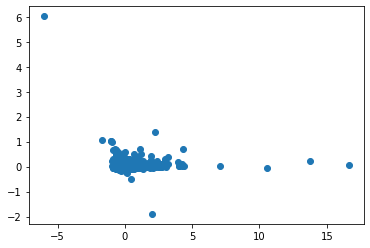

In [166]:
%matplotlib inline
residuals = np.array(y_test) - lm_pred
plt.scatter(residuals,lm_pred)

plt.show()

## Ensamble: Random Forest

In [244]:
forest_reg = RandomForestRegressor(random_state=1)
forest_model = forest_reg.fit(X_train_std, y_train)
forest_pred = forest_model.predict(X_test_std)

print("Out of sample R-squared:",r2_score(y_test, forest_pred))
print("MSE:",mean_squared_error(y_test, forest_pred))

Out of sample R-squared: 0.02538118633192954
MSE: 0.10487149964859539


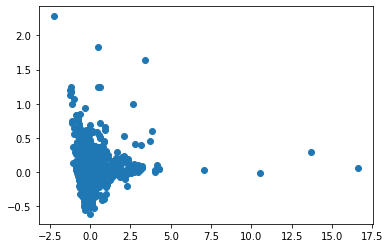

In [245]:
%matplotlib inline
residuals = np.array(y_test) - forest_pred
plt.scatter(residuals,forest_pred)

plt.show()

<AxesSubplot:ylabel='Features'>

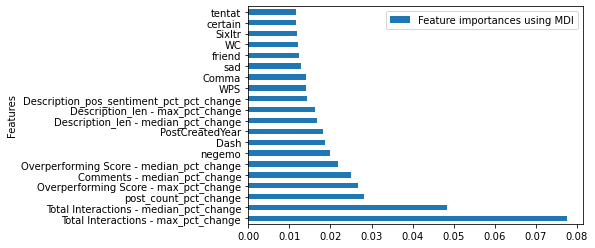

In [246]:
importances = forest_model.feature_importances_
forest_importances_df = (pd.DataFrame({
    "Features":X_train_std.columns,
    "Feature importances using MDI":importances})
                         .sort_values(by="Feature importances using MDI",ascending=False)
                         .head(20))
forest_importances_df.plot.barh(x="Features",y="Feature importances using MDI")


## Ensamble: Gradient Boosting

In [247]:
gbt_reg = GradientBoostingRegressor(random_state=1)
gbt_model = gbt_reg.fit(X_train_std, y_train)
gbt_predicted = gbt_model.predict(X_test_std)

print("Out of sample R-squared:",r2_score(y_test, gbt_predicted))
print("MSE:",mean_squared_error(y_test, gbt_predicted))

Out of sample R-squared: 0.02684612619028215
MSE: 0.10471386833911735


<AxesSubplot:ylabel='Features'>

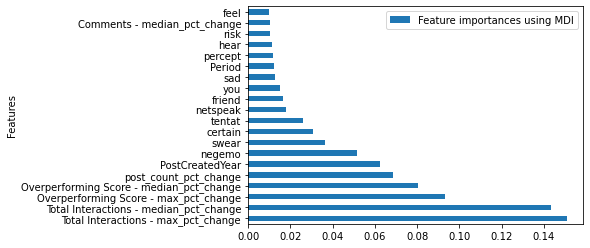

In [248]:
importances = gbt_model.feature_importances_
gbt_importances_df = (pd.DataFrame({
    "Features":X_train_std.columns,
    "Feature importances using MDI":importances})
                         .sort_values(by="Feature importances using MDI",ascending=False)
                         .head(20))
gbt_importances_df.plot.barh(x="Features",y="Feature importances using MDI")


## Ensamble: LGBM

In [249]:
lgbm_reg = LGBMRegressor(random_state=1)
lgbm_model = lgbm_reg.fit(X_train_std, y_train)
lgbm_predicted = lgbm_model.predict(X_test_std)

print("Out of sample R-squared:",r2_score(y_test, lgbm_predicted))
print("MSE:",mean_squared_error(y_test, lgbm_predicted))

Out of sample R-squared: 0.035573390603042654
MSE: 0.1037747921649653


<AxesSubplot:ylabel='Features'>

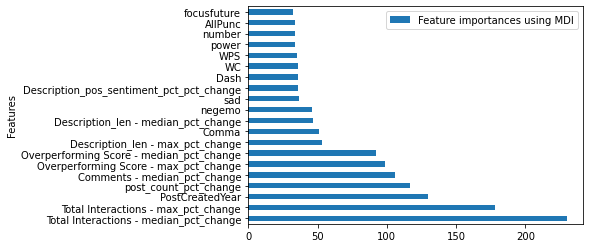

In [250]:
importances = lgbm_reg.feature_importances_
lgbm_importances_df = (pd.DataFrame({
    "Features":X_train_std.columns,
    "Feature importances using MDI":importances})
                         .sort_values(by="Feature importances using MDI",ascending=False)
                         .head(20))
lgbm_importances_df.plot.barh(x="Features",y="Feature importances using MDI")

### Prediction error closer look

In [292]:
X_std = pd.concat([X_train_std,X_test_std])
lgbm_predicted_full = lgbm_model.predict(X_std)
pred_error = np.abs(lgbm_predicted_full-y)

<AxesSubplot:xlabel='index'>

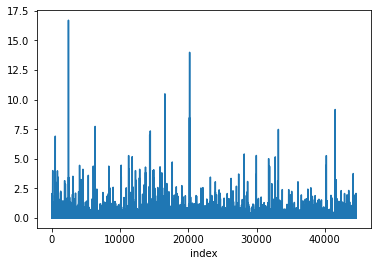

In [296]:
pred_error.plot()

### Data points that has large prediction error

In [312]:
delta_input_model.loc[list(pred_error[pred_error>np.quantile(pred_error,0.75)].index)].iloc[:,:15].mean()

Followers at Posting - last_pct_change      0.061082
Followers at Posting - max_pct_change       0.058792
post_count_pct_change                       0.606265
Total Interactions - median_pct_change      0.128092
Total Interactions - max_pct_change         0.242700
Comments - median_pct_change                0.460439
Comments - max_pct_change                   0.847574
Overperforming Score - median_pct_change   -0.220449
Overperforming Score - max_pct_change      -0.179832
Description_len - median_pct_change         1.152329
Description_len - max_pct_change            1.577924
Description_pos_sentiment_pct_pct_change   -0.010131
is_linked_pct_pct_change                    0.000046
PostCreatedYear                             4.118924
PostCreatedMonth                            5.556323
dtype: float64

### Data points that has small prediction error

In [313]:
delta_input_model.loc[list(pred_error[pred_error<np.quantile(pred_error,0.25)].index)].iloc[:,:15].mean()

Followers at Posting - last_pct_change      0.002851
Followers at Posting - max_pct_change       0.003404
post_count_pct_change                       0.375352
Total Interactions - median_pct_change      0.104043
Total Interactions - max_pct_change         0.177494
Comments - median_pct_change                0.377337
Comments - max_pct_change                   0.684160
Overperforming Score - median_pct_change   -0.315787
Overperforming Score - max_pct_change      -0.094028
Description_len - median_pct_change         1.310897
Description_len - max_pct_change            1.685334
Description_pos_sentiment_pct_pct_change   -0.013399
is_linked_pct_pct_change                    0.000005
PostCreatedYear                             4.747982
PostCreatedMonth                            5.619193
dtype: float64

## Ensamble: XGBoost

In [251]:
xgb_reg = XGBRegressor(random_state=1)
xgb_model = xgb_reg.fit(X_train_std, y_train)
xgb_predicted = xgb_model.predict(X_test_std)

print("Out of sample R-squared:",r2_score(y_test, xgb_predicted))
print("MSE:",mean_squared_error(y_test, xgb_predicted))

Out of sample R-squared: -0.01977789231710214
MSE: 0.10973073305785905


<AxesSubplot:ylabel='Features'>

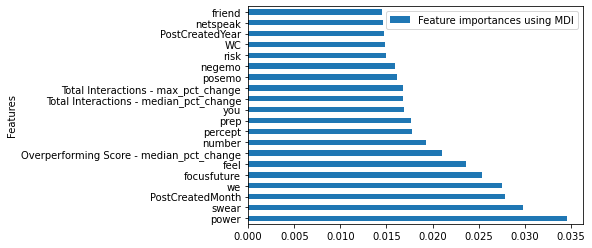

In [252]:
importances = xgb_model.feature_importances_
xgb_importances_df = (pd.DataFrame({
    "Features":X_train_std.columns,
    "Feature importances using MDI":importances})
                         .sort_values(by="Feature importances using MDI",ascending=False)
                         .head(20))
xgb_importances_df.plot.barh(x="Features",y="Feature importances using MDI")

## Neural Networks: Tensorflow

In [133]:
def baseline_model():
            # create model
            model = Sequential()
            model.add(Dense(100, input_dim=X_test_std.shape[1], activation='relu'))
            model.add(Dense(100, activation='relu'))
            model.add(Dense(100, activation='relu'))
            model.add(Dense(1))
            # Compile model
            model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mse"])
            return model

In [137]:
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=10, verbose=True)
estimator.fit(X_train_std, y_train,callbacks=keras.callbacks.EarlyStopping(patience=5))
prediction_nn = estimator.predict(X_test_std)
print("Out of sample R-squared:",r2_score(y_test, prediction_nn))

Epoch 1/100
2989/2989 [==============================] - 19s 6ms/step - loss: 0.0745 - mse: 0.0745
Epoch 2/100
2989/2989 [==============================] - 20s 7ms/step - loss: 0.0695 - mse: 0.0695
Epoch 3/100
2989/2989 [==============================] - 19s 6ms/step - loss: 0.0684 - mse: 0.0684
Epoch 4/100
2989/2989 [==============================] - 18s 6ms/step - loss: 0.0653 - mse: 0.0653
Epoch 5/100
2989/2989 [==============================] - 19s 6ms/step - loss: 0.0633 - mse: 0.0633
Epoch 6/100
2989/2989 [==============================] - 18s 6ms/step - loss: 0.0615 - mse: 0.0615
Epoch 7/100
2989/2989 [==============================] - 19s 6ms/step - loss: 0.0576 - mse: 0.0576
Epoch 8/100
2989/2989 [==============================] - 19s 6ms/step - loss: 0.0553 - mse: 0.0553
Epoch 9/100
2989/2989 [==============================] - 19s 7ms/step - loss: 0.0521 - mse: 0.0521
Epoch 10/100
2989/2989 [==============================] - 19s 7ms/step - loss: 0.0513 - mse: 0.0513
Epoch 11/

In [142]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train_std, y_train)
eli5.show_weights(perm, feature_names = X_train_std.columns.tolist())

2989/2989 [==============================] - 9s 3ms/step


Weight,Feature
0.2610 ± 0.0148,Total Interactions - median_pct_change
0.1559 ± 0.0149,PostCreatedYear
0.1000 ± 0.0111,Total Interactions - max_pct_change
0.0759 ± 0.0115,Overperforming Score - max_pct_change
0.0698 ± 0.0079,post_count_pct_change
0.0596 ± 0.0203,Description_pos_sentiment_pct_pct_change
0.0534 ± 0.0081,PostCreatedMonth
0.0477 ± 0.0085,prep
0.0443 ± 0.0151,Comments - median_pct_change
0.0428 ± 0.0117,conj


# PCA

In [191]:
from sklearn.decomposition import PCA
pca = PCA(.8)
pca.fit(X_train_std, y_train)
X_train_std_pca = pca.transform(X_train_std)
X_test_std_pca = pca.transform(X_test_std)

In [192]:
pca.n_components_

56



 PCA :

[[ 1.00000000e+00  3.90338748e-17 -6.92386588e-17 ... -1.55670810e-17
   2.32344493e-17 -1.34759806e-17]
 [-3.90338748e-17  1.00000000e+00  8.29891711e-15 ... -3.46944695e-17
   9.02056208e-17 -1.45716772e-16]
 [ 6.92386588e-17 -8.32667268e-15  1.00000000e+00 ...  1.73472348e-17
  -2.77555756e-17 -1.52655666e-16]
 ...
 [ 1.55670810e-17  9.09886143e-17  7.58122822e-18 ...  1.00000000e+00
   5.65658631e-14  3.28036209e-15]
 [-2.32344493e-17 -1.06982485e-17 -8.65383065e-17 ... -5.64617797e-14
   1.00000000e+00 -1.43973917e-14]
 [ 1.34759806e-17  5.55111512e-17  5.37764278e-17 ... -3.19883009e-15
   1.40963630e-14  1.00000000e+00]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.




 Unrotated FA :

[[ 2.57699955e+00  1.54959420e-16 -1.10635772e-16 ...  0.00000000e+00
   0.00000000e+00 -0.00000000e+00]
 [-2.32881009e-16  1.71473989e+00  5.76692730e-15 ...  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 1.81129674e-16 -6.09197985e-15  1.57405646e+00 ...  0.00000000e+00
  -0.00000000e+00  0.00000000e+00]
 ...
 [ 5.24806989e-17  1.28754817e-16 -2.13611547e-17 ... -0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.43314040e-17  6.59077008e-17  1.20521558e-16 ... -0.00000000e+00
   0.00000000e+00 -0.00000000e+00]
 [ 2.04724899e-17  3.64294375e-17 -5.91642012e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.




 Varimax FA :

[[ 2.57699955e+00 -1.54731321e-18  1.24742439e-18 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.28741163e-16  1.71473989e+00  6.26819304e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.12790326e-16 -7.61940979e-16  1.57405646e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 5.24806989e-17  1.28754817e-16 -2.13611547e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.43314040e-17  6.59077008e-17  1.20521558e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.04724899e-17  3.64294375e-17 -5.91642012e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.


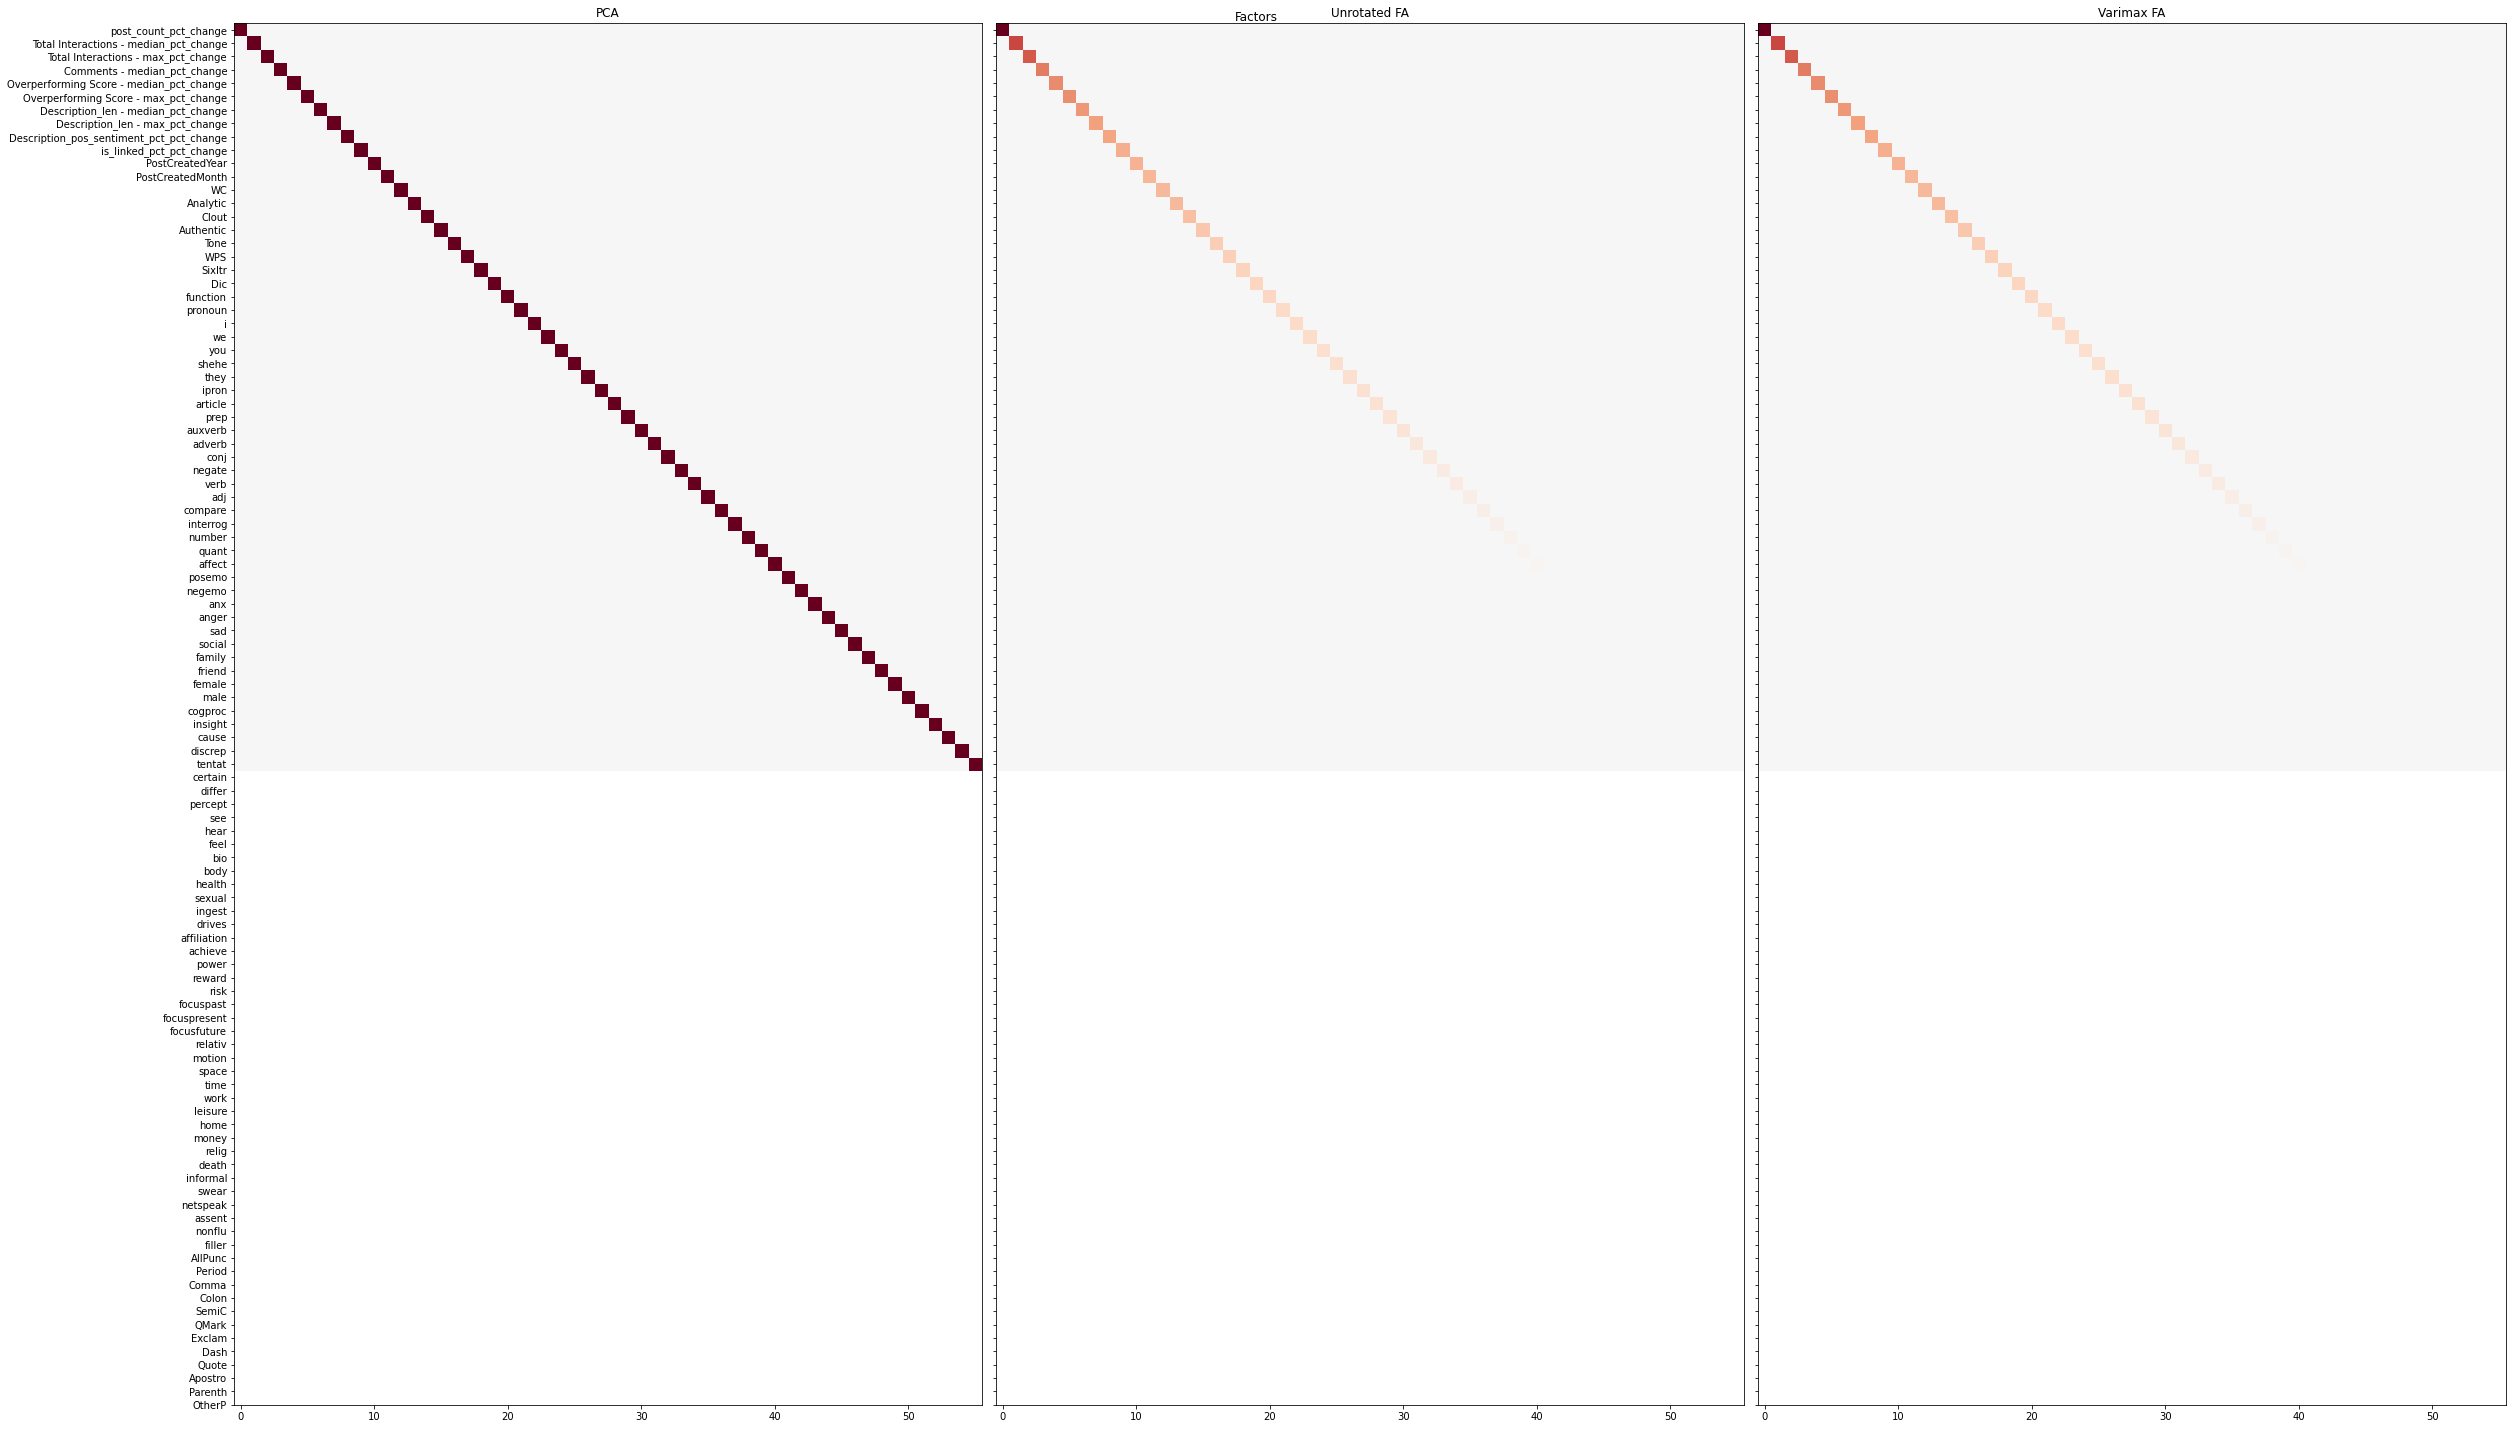

In [223]:
from sklearn.decomposition import FactorAnalysis, PCA
n_comps = 56

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]
fig, axes = plt.subplots(ncols=len(methods), figsize=(35, 20))

feature_names=X_train_std.columns

for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X_train_std_pca)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    print(components)

    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    #ax.set_xticks([0, 1])
    #ax.set_xticklabels(["Comp. 1", "Comp. 2"])
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

In [226]:
loadings = pd.DataFrame(pca.components_.T, index=feature_names, columns=['x'+str(i) for i in range(1,57)])

In [227]:
loadings.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56
post_count_pct_change,0.001198,0.000074,-0.003351,-0.000122,0.002699,-0.012347,0.023727,0.097796,0.085831,0.040774,...,0.004160,0.079693,0.052332,0.026821,-0.143871,0.213880,0.109935,0.189471,-0.005705,-0.075501
Total Interactions - median_pct_change,0.005296,0.003809,-0.029766,-0.028449,0.026751,-0.016048,0.079631,0.435009,0.335882,0.121324,...,-0.040805,-0.044300,0.036401,-0.014669,-0.029095,0.059673,-0.007649,0.030824,0.024096,0.000628
Total Interactions - max_pct_change,0.007265,0.002752,-0.028859,-0.021317,0.024424,-0.024359,0.081742,0.431947,0.337655,0.126418,...,0.008452,0.023413,0.028962,0.001470,-0.059987,0.092597,0.024530,0.057223,0.002471,-0.022003
Comments - median_pct_change,0.002103,0.000718,-0.018033,-0.019839,0.024007,-0.008303,0.049650,0.316316,0.252872,0.072708,...,-0.075191,-0.099312,0.042601,0.017748,0.048098,-0.053389,-0.021216,-0.036933,0.024918,0.048325
Overperforming Score - median_pct_change,-0.003381,0.000849,0.000372,-0.010463,-0.004646,-0.005684,0.012683,0.010599,0.019883,0.011347,...,-0.077194,-0.130718,-0.016003,-0.020067,-0.067504,0.212049,0.039108,0.094272,0.047162,-0.036252


In [228]:
loadings.to_csv('PCA_loadings_monthly_data.csv',index=False)

# Prediction with PCA transformed data

## Linear Regression

In [203]:
X_train_std_pca_cons = sm.add_constant(X_train_std_pca)
base_linear_pca = sm.OLS(list(y_train), X_train_std_pca_cons)
base_linear_pca_fitted = base_linear_pca.fit()
print(base_linear_pca_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     17.76
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          9.41e-169
Time:                        01:24:19   Log-Likelihood:                -2541.5
No. Observations:               29882   AIC:                             5197.
Df Residuals:                   29825   BIC:                             5670.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0159      0.002     10.393      0.0

In [229]:
p_values_pca = base_linear_pca_fitted.summary2().tables[1]['P>|t|']
p_values_pca[p_values_pca<0.05]

const    2.937622e-25
x6       1.961025e-02
x7       4.080922e-08
x8       5.124568e-97
x9       4.529123e-65
x10      7.511532e-15
x12      2.916540e-07
x13      1.296611e-04
x30      1.436676e-05
x36      1.517452e-02
x38      3.795507e-02
x39      1.762362e-02
x43      3.339935e-02
x51      8.707980e-04
x52      1.864352e-05
x54      2.647020e-02
Name: P>|t|, dtype: float64

In [242]:
features = pd.DataFrame(p_values_pca[p_values_pca<0.05]).reset_index()
features.sort_values(by='P>|t|')

,index,P>|t|
3,x8,5.124568e-97
4,x9,4.529123e-65
0,const,2.937622e-25
5,x10,7.511532e-15
2,x7,4.080922e-08
6,x12,2.916540e-07
8,x30,1.436676e-05
14,x52,1.864352e-05
7,x13,1.296611e-04
13,x51,8.707980e-04


In [234]:
loadings[list(features.iloc[1:,0])].to_csv('important_features.csv')

In [209]:
X_test_std_pca_cons = sm.add_constant(X_test_std_pca)
lm_pca_pred = base_linear_pca_fitted.predict(sm.add_constant(X_test_std_pca_cons))
print("Out of sample R-squared:",r2_score(y_test, lm_pca_pred))

Out of sample R-squared: 0.002675796477209391


In [240]:
mean_squared_error(y_test, lm_pca_pred)

0.10731465819507247

## Random Forest

In [210]:
forest_reg_pca = RandomForestRegressor(random_state=1)
forest_pca_model = forest_reg.fit(X_train_std_pca, y_train)
forest_pca_pred = forest_model.predict(X_test_std_pca)

print("Out of sample R-squared:",r2_score(y_test, forest_pca_pred))

Out of sample R-squared: -0.0120192064255924


In [239]:
mean_squared_error(y_test, forest_pca_pred)

0.10889587843230271

## Gradient Boosting

In [216]:
gbt_pca_reg = GradientBoostingRegressor(random_state=1)
gbt_pca_model = gbt_reg.fit(X_train_std_pca, y_train)
gbt_pca_predicted = gbt_model.predict(X_test_std_pca)

print("Out of sample R-squared:",r2_score(y_test, gbt_pca_predicted))

Out of sample R-squared: 0.021078942776911025


In [238]:
mean_squared_error(y_test, gbt_pca_predicted)

0.10533443215835295

## LGBM

In [235]:
lgbm_pca_reg = LGBMRegressor(random_state=1)
lgbm_pca_model = lgbm_pca_reg.fit(X_train_std_pca, y_train)
lgbm_pca_predicted = lgbm_pca_model.predict(X_test_std_pca)

print("Out of sample R-squared:",r2_score(y_test, lgbm_pca_predicted))

Out of sample R-squared: 0.021678700882132418


In [237]:
mean_squared_error(y_test, lgbm_pca_predicted)

0.10526989663837437

As expected, PCA transformation did not improve the prediction quality.